[Open this notebook on Colab](https://colab.research.google.com/github/probabll/ntmi-tutorials/blob/main/T6.ipynb)

# Guide

* Before working on this tutorial, you should have worked through the [introduction to PyTorch](https://github.com/probabll/ntmi-tutorials/blob/main/PyTorch.ipynb).
* Check the entire notebook before you get started, this gives you an idea of what lies ahead.
* Note that, as always, the notebook contains a condensed version of the theory We recommend you read the theory part before the LC session.


## ILOs

After completing this lab you should be able to

* develop neural sequence labellers in PyTorch
* estimate parameters via MLE
* predict tag sequences for novel data
* evaluate tagging performance

## General Notes

* In this notebook you are expected to use $\LaTeX$.
* Use python3.
* Use Torch.
* This tutorial runs smoothly enough on CPU.

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally you will need to install some additional packages, ask your TA for help if you have problems setting up.


## Table of Contents



### Topics

* [Data](#sec:Data)
	* [Vocabulary](#sec:Vocabulary)
	* [Corpus and Data Loader](#sec:Corpus_and_Data_Loader)
* [Neural Tagger](#sec:Neural_Tagger)
	* [Formalisation](#sec:Formalisation)
	* [Encoder](#sec:Encoder)
	* [Parallel Tagging](#sec:Parallel_Tagging)
	* [Decoder](#sec:Decoder)
	* [Sequential Tagging](#sec:Sequential_Tagging)
	 	* [Markov Tagger](#sec:Markov_Tagger)
	 	* [Autoregressive Tagger](#sec:Autoregressive_Tagger)
* [Training and Evaluation](#sec:Training_and_Evaluation)
	* [Perplexity](#sec:Perplexity)
	* [Decision rules and tagging accuracy](#sec:Decision_rules_and_tagging_accuracy)
* [Experiment](#sec:Experiment)


### Table of ungraded exercises

1. [Tagger](#ungraded-1)
1. [BasicEncoder](#ungraded-2)
1. [ParallelTagger](#ungraded-3)
1. [SequentialTagger](#ungraded-4)


### Table of graded exercises

*Important:* The grader may re-run your notebook to investigate its correctness, but you must upload your notebook with the cells already run and make sure that all your answers are visible without the need to re-run the notebook.


Exercises have equal weights.


1. [POS tagging data](#graded-1)
1. [BidirectionalEncoder](#graded-2)
1. [NGramDecoder](#graded-3)
1. [AutoregressiveDecoder](#graded-4)
1. [Comparison](#graded-5)

## Setting up

In [43]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)

In [44]:

!pip install nltk
!pip install tabulate

<a name='sec:Data'></a>
# Data

In this tutorial we will develop models for sequence labelling. So our data for this tutorial will be collections of sentences, or *corpora*, annotated with token-level tags (e.g., part-of-speech tags or named-entity tags, etc). See [Section 8.2 and 8.3 of the textbook](https://web.stanford.edu/~jurafsky/slp3/8.pdf) to learn more about the data type.

We will use corpora available in NLTK.

In [45]:
import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [46]:
from nltk.corpus import treebank

# The treebank is small enough for experiments on CPU
# even though it is small, it's an okay size for POS tagging

corpus = treebank

The method `tagged_sents` will give us a view of tokenized sentences with their token lag tag annotation:

In [47]:
example = corpus.tagged_sents(tagset='universal')[0]
example

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [48]:
from tabulate import tabulate

def tostring(seq_pair, vertical=True, headers=['Word', 'Tag']):
    """
    :param seq_pair: a sequence of pairs, each pair is a token and a tag.
    :param vertical: use True for vertical printing with tabulate.
    :return: a string representing the sequence of pairs.
    """
    if vertical:
        return tabulate(list(seq_pair), headers=headers)
    else:
        return ' '.join(f'{w}/{t}' for w, t in seq_pair)

def tostring2(tok_seq, tag_seq, vertical=True, headers=['Word', 'Tag']):
    """
    :param tok_seq: a sequence of tokens
    :param tag_seq: a corresponding sequence of tags
        they must have the same length
    :param vertical: use True for vertical printing with tabulate.
    :return: a string representing the sequence of pairs.
    """
    assert len(tok_seq) == len(tag_seq), "I need the same number of elements in both sequences"
    return tostring(zip(tok_seq, tag_seq), vertical=vertical, headers=headers)

In [49]:
print(tostring(example, vertical=False))

Pierre/NOUN Vinken/NOUN ,/. 61/NUM years/NOUN old/ADJ ,/. will/VERB join/VERB the/DET board/NOUN as/ADP a/DET nonexecutive/ADJ director/NOUN Nov./NOUN 29/NUM ./.


In [50]:
print(tostring(example, vertical=True))

Word          Tag
------------  -----
Pierre        NOUN
Vinken        NOUN
,             .
61            NUM
years         NOUN
old           ADJ
,             .
will          VERB
join          VERB
the           DET
board         NOUN
as            ADP
a             DET
nonexecutive  ADJ
director      NOUN
Nov.          NOUN
29            NUM
.             .


In [51]:
def split_nltk_corpus(corpus, num_heldout, max_length=30, delete_traces=False, rng=np.random.RandomState(42)):
    """
    Shuffle and split a corpus.

    :param corpus: an NLTK corpus of tagged sequences, each sequence is a pair, each pair is a token and a tag.
    :param num_heldout: number of sentences in the dev/test sets
    :param max_length: discard sentences longer than this
    :param delete_traces: the PennTreebank uses something called a "trace" to
     annotate certain linguistic structures that we do not want to use in this class
     use delete_traces=True to remove them from the data

    :return:
        (training word sequences, training tag sequences),
        (dev word sequences, dev tag sequences),
        (test word sequences, test tag sequences),
    """
    tagged_sentences = corpus.tagged_sents(tagset='universal')
    # do not change the seed in here
    order = rng.permutation(np.arange(len(tagged_sentences)))
    word_sequences = [[w.lower() for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]
    tag_sequences = [[t for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]

    if delete_traces:
        no_traces_word_sequences = []
        no_traces_tag_sequences = []
        for ws, ts in zip(word_sequences, tag_sequences):
            words = []
            tags = []
            for w, t in zip(ws, ts):
                if not w.startswith("*"):
                    words.append(w)
                    tags.append(t)
            no_traces_word_sequences.append(words)
            no_traces_tag_sequences.append(tags)
        word_sequences = no_traces_word_sequences
        tag_sequences = no_traces_tag_sequences

    return (word_sequences[2*num_heldout:], tag_sequences[2*num_heldout:]), (word_sequences[num_heldout:2*num_heldout], tag_sequences[num_heldout:2*num_heldout]), (word_sequences[:num_heldout], tag_sequences[:num_heldout])



For `treebank` this will take about 10 seconds.

In [52]:
%%time
(training_x, training_y), (dev_x, dev_y), (test_x, test_y) = split_nltk_corpus(
    corpus,
    num_heldout=100 if corpus is treebank else 1000,
    delete_traces=corpus is treebank
)
print(f"Number of sentences: training={len(training_x)} dev={len(dev_x)} test={len(test_x)}")

Number of sentences: training=2486 dev=100 test=100
CPU times: user 3.67 s, sys: 371 ms, total: 4.04 s
Wall time: 5.11 s


In [53]:
print("# A few training sentences\n\n")
for n in range(3):
    print(tostring2(training_x[n], training_y[n]))
    print()

# A few training sentences


Word          Tag
------------  -----
they          PRON
know          VERB
0             X
he            PRON
is            VERB
generally     ADV
opposed       VERB
to            PRT
cop-killer    ADJ
bullets       NOUN
,             .
but           CONJ
that          ADP
he            PRON
had           VERB
some          DET
reservations  NOUN
about         ADP
the           DET
language      NOUN
in            ADP
the           DET
legislation   NOUN
.             .
''            .

Word            Tag
--------------  -----
california      NOUN
's              PRT
education       NOUN
department      NOUN
suspects        VERB
adult           NOUN
responsibility  NOUN
for             ADP
erasures        NOUN
at              ADP
40              NUM
schools         NOUN
that            DET
changed         VERB
wrong           ADJ
answers         NOUN
to              PRT
right           ADJ
ones            NOUN
on              ADP
a               DET
state

<a name='graded-1'> **Graded Exercise 1 - POS tagging data** </a>

Using the training data:
* Plot the marginal frequency (number of times a tag occurs divided by total occurrences of tags) of the tags in the dataset
* Plot the most frequent nouns, verbs, adjectives, and adverbs and their conditional frequency (given a tag, number of times a word occurs divided by number of occurrences of that tag). Use top-10.
* What's the proportion of the vocabulary (of words) that exhibit ambiguity of POS. List some examples.

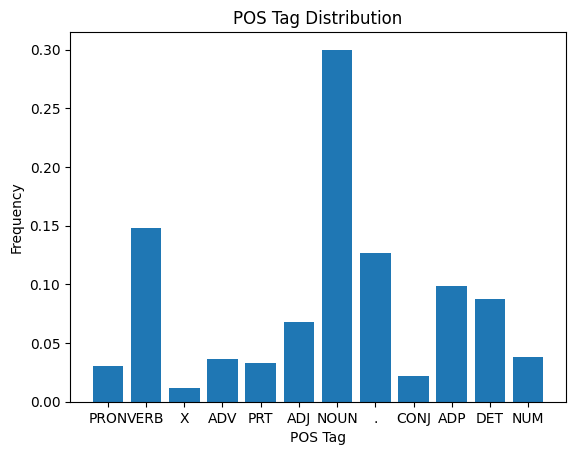

NOUN: [('%', 231), ('mr.', 218), ('company', 118), ('year', 114), ('u.s.', 88), ('market', 88), ('stock', 84), ('trading', 80), ('program', 68), ('new', 64)]
VERB: [('is', 367), ('said', 320), ('are', 206), ('was', 206), ('has', 170), ('be', 166), ('have', 160), ('will', 136), ('were', 122), ('says', 100)]
ADJ: [('new', 82), ('other', 69), ('more', 57), ('last', 48), ('many', 47), ('japanese', 44), ('such', 39), ('next', 31), ('higher', 29), ('first', 29)]
ADV: [("n't", 184), ('also', 98), ('not', 77), ('more', 43), ('even', 38), ('now', 37), ('so', 36), ('when', 36), ('up', 34), ('only', 31)]
Ambiguous words: 458 (6.29%)
Examples: [('but', {'ADV', 'CONJ'}), ('that', {'ADV', 'ADP', 'DET'}), ('about', {'ADV', 'ADP', 'PRT'}), ('the', {'NOUN', 'DET'}), ('in', {'ADP', 'NOUN', 'PRT'}), ("'s", {'VERB', 'PRT'}), ('suspects', {'NOUN', 'VERB'}), ('answers', {'NOUN', 'VERB'}), ('right', {'ADV', 'NOUN', 'ADJ'}), ('on', {'ADP', 'NOUN', 'PRT'})]


In [54]:
# CONTRIBUTE YOUR SOLUTION/CODE

import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Stap 1: Marginale frequentie van POS-tags
tag_counts = Counter()
for sentence in training_y:
    for tag in sentence:
        tag_counts[tag] += 1

total_tags = sum(tag_counts.values())
plt.bar(tag_counts.keys(), [tag_counts[tag] / total_tags for tag in tag_counts])
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.title("POS Tag Distribution")
plt.show()

# Stap 2: Top-10 woorden per NOUN, VERB, ADJ, ADV
tag_to_words = defaultdict(Counter)
for i in range(len(training_x)):
    for j in range(len(training_x[i])):
        word = training_x[i][j]
        tag = training_y[i][j]
        tag_to_words[tag][word] += 1

for tag in ["NOUN", "VERB", "ADJ", "ADV"]:
    print(f"{tag}: {tag_to_words[tag].most_common(10)}")

# Stap 3: Ambiguïteit in POS-tags
word_tags = defaultdict(set)
for i in range(len(training_x)):
    for j in range(len(training_x[i])):
        word = training_x[i][j]
        tag = training_y[i][j]
        word_tags[word].add(tag)

ambiguous_words = {}
for word, tags in word_tags.items():
    if len(tags) > 1:
        ambiguous_words[word] = tags

print(f"Ambiguous words: {len(ambiguous_words)} ({len(ambiguous_words) / len(word_tags) * 100:.2f}%)")
print("Examples:", list(ambiguous_words.items())[:10])


<a name='sec:Vocabulary'></a>
## Vocabulary

As always when dealing with NLP models, we need an object to maintain our vocabulary of known tokens. This time we will rely on word-tokenization rather than BPE tokenization (the reason behind this choice is that in POS tagging we **need** to maintain a one-to-one alignment between our word sequence and our tag sequence, BPE tokenisation could easily break that). Fortunately, NLK corpora are already tokenized.

Our vocabulary class will maintain the set of known tokens, and a dictionary to convert tokens to codes and codes back to tokens. The class will also take care of some special symbols (e.g., BOS, EOS, UNK, PAD).

Finally, if later on you test your model on sentences that are not word tokenized, you can use `nlt.tokenize.word_tokenize` or any other tokenizer you like (as long as the level of tokenization is similar to the one you used for training your model.

In [55]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

This is how you can tokenize English sentences (but remember that we don't need to redo this for the training/dev/test data from NLKT):

In [56]:
word_tokenize("This is a sentence, and this is another.")

['This', 'is', 'a', 'sentence', ',', 'and', 'this', 'is', 'another', '.']

We will adapt one of the classes we developed in previous tutorials, and this class will be used for maintaining both the vocabulary of known tokens and the set of known tags.

In [57]:
import numpy as np
from itertools import chain
from collections import Counter, OrderedDict

class Vocabulary:

    def __init__(self, corpus: list, min_freq=1):
        """
        :param corpus: list of documents, each document is a list of tokens, each token is a string
        :param min_freq: words that occur less than this value are discarded
        """
        # Make the vocabulary of known words

        # Count word occurrences
        counter = Counter(chain(*corpus))
        # sort them by frequency
        sorted_by_freq_tuples = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)

        # Special tokens
        self.pad_token = "-PAD-"
        self.bos_token = "-BOS-"
        self.eos_token = "-EOS-"
        self.unk_token = "-UNK-"
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3

        self.known_symbols = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]
        self.counts = [0, 0]

        # Vocabulary
        self.word2id = OrderedDict()
        self.word2id[self.pad_token] = self.pad_id
        self.word2id[self.bos_token] = self.bos_id
        self.word2id[self.eos_token] = self.eos_id
        self.word2id[self.unk_token] = self.unk_id
        self.min_freq = min_freq
        for w, n in sorted_by_freq_tuples:
            if n >= min_freq: # discard infrequent words
                self.word2id[w] = len(self.known_symbols)
                self.known_symbols.append(w)
                self.counts.append(n)

        # store the counts for later
        self.counts = np.array(self.counts)

    def __len__(self):
        return len(self.known_symbols)

    def __getitem__(self, word: str):
        """
        :param word: a string zz
        :return: the id (int) of a word (str)
            unk_id is returned for unknown words
        """
        return self.word2id.get(word, self.unk_id)

    def encode(self, doc: list, add_bos=False, add_eos=False, pad_right=0):
        """
        Transform a document into a sequence of integer token identifiers.
        :param doc: list of tokens, each token is a string
        :param add_bos: whether to add the BOS token
        :param add_eos: whether to add the EOS token
        :param pad_right: number of suffix padding tokens

        :return: a list of codes (possibly with BOS and EOS added as well as padding)
        """
        return [self.word2id.get(w, self.unk_id) for w in chain([self.bos_token] * int(add_bos), doc, [self.eos_token] * int(add_eos), [self.pad_token] * pad_right)]

    def batch_encode(self, docs: list, add_bos=False, add_eos=False):
        """
        Transform a batch of documents into a numpy array of integer token identifiers.
        This will pad the shorter documents to the length of the longest document.

        :param docs: a list of documents
        :param add_bos: whether to add the BOS token
        :param add_eos: whether to add the EOS token
        :param pad_right: number of suffix padding tokens

        :return: numpy array with shape [len(docs), longest_doc + add_bos + add_eos]
        """
        max_len = max(len(doc) for doc in docs)
        return np.array([self.encode(doc, add_bos=add_bos, add_eos=add_eos, pad_right=max_len-len(doc)) for doc in docs])

    def decode(self, ids, strip_pad=False):
        """
        Transform a np.array document into a list of tokens.
        :param ids: np.array with shape [num_tokens]
        :param strip_pad: whether PAD tokens should be deleted from the output

        :param return: list of strings with size [num_tokens - num_padding]
        """
        if strip_pad:
            return [self.known_symbols[id] for id in ids if id != self.pad_id]
        else:
            return [self.known_symbols[id] for id in ids]

    def batch_decode(self, docs, strip_pad=False):
        """
        Transform a np.array collection of documents into a collection of lists of tokens.
        :param ids: np.array with shape [num_docs, max_length]
        :param strip_pad: whether PAD tokens should be deleted from the output

        :return: list of documents, each a list of tokens, each token a string
        """
        return [self.decode(doc, strip_pad=strip_pad) for doc in docs]

Let's see how this works:

In [58]:
# we get a vocabulary for words
word_vocab = Vocabulary(training_x, min_freq=2)
# and a vocabulary for tags
tag_vocab = Vocabulary(training_y, min_freq=1)
# you can see their sizes V and C:
len(word_vocab), len(tag_vocab)

(3316, 16)

The `encode` method turns a sequence of (str) symbols into a sequence of (int) codes:

In [59]:
print(tostring2(word_vocab.encode(training_x[0]), tag_vocab.encode(training_y[0]), vertical=True))

  Word    Tag
------  -----
    41     13
   894      5
    12     15
    32     13
    15      5
   587     11
  1064      5
     8     12
  1635      9
  1636      4
     6      6
    37     14
    16      7
    32     13
    60      5
    65      8
  2178      4
    49      7
     5      8
  2179      4
    10      7
     5      8
   475      4
     4      6
    18      6


We can also have `encode` add some special symbols for us (but remember to be consistent, you should always have token sequences and tag sequences that match in length):

In [60]:
print(tostring2(word_vocab.encode(training_x[0], add_eos=True), tag_vocab.encode(training_y[0], add_eos=True)))

  Word    Tag
------  -----
    41     13
   894      5
    12     15
    32     13
    15      5
   587     11
  1064      5
     8     12
  1635      9
  1636      4
     6      6
    37     14
    16      7
    32     13
    60      5
    65      8
  2178      4
    49      7
     5      8
  2179      4
    10      7
     5      8
   475      4
     4      6
    18      6
     2      2


Here for example, we will add BOS, EOS, and we are going to encode and decode:

In [61]:
print(tostring2(word_vocab.decode(word_vocab.encode(training_x[0], add_bos=True, add_eos=True)), tag_vocab.decode(tag_vocab.encode(training_y[0], add_bos=True, add_eos=True))))

Word          Tag
------------  -----
-BOS-         -BOS-
they          PRON
know          VERB
0             X
he            PRON
is            VERB
generally     ADV
opposed       VERB
to            PRT
cop-killer    ADJ
bullets       NOUN
,             .
but           CONJ
that          ADP
he            PRON
had           VERB
some          DET
reservations  NOUN
about         ADP
the           DET
language      NOUN
in            ADP
the           DET
legislation   NOUN
.             .
''            .
-EOS-         -EOS-


We can also encode and decode entire batches of sequences. This will use pad symbols/codes to make the sequences in the same batch have the same length:

In [62]:
word_vocab.batch_encode(training_x[:2], add_bos=False, add_eos=True)

array([[  41,  894,   12,   32,   15,  587, 1064,    8, 1635, 1636,    6,
          37,   16,   32,   60,   65, 2178,   49,    5, 2179,   10,    5,
         475,    4,   18,    2],
       [ 476,   13, 1294,  150, 2180,    3,    3,   14,    3,   27,  437,
         895,   16,  588,  896,  759,    8,  331,  897,   22,    9, 2181,
         332,    4,    2,    0]])

In [63]:
word_vocab.batch_decode(word_vocab.batch_encode(training_x[:2], add_bos=False, add_eos=True), strip_pad=True)

[['they',
  'know',
  '0',
  'he',
  'is',
  'generally',
  'opposed',
  'to',
  'cop-killer',
  'bullets',
  ',',
  'but',
  'that',
  'he',
  'had',
  'some',
  'reservations',
  'about',
  'the',
  'language',
  'in',
  'the',
  'legislation',
  '.',
  "''",
  '-EOS-'],
 ['california',
  "'s",
  'education',
  'department',
  'suspects',
  '-UNK-',
  '-UNK-',
  'for',
  '-UNK-',
  'at',
  '40',
  'schools',
  'that',
  'changed',
  'wrong',
  'answers',
  'to',
  'right',
  'ones',
  'on',
  'a',
  'statewide',
  'test',
  '.',
  '-EOS-']]

<a name='sec:Corpus_and_Data_Loader'></a>
## Corpus and Data Loader

We will be developing our models in torch, thus we need to wrap our corpus into a `Dataset` and a `DataLoader`.

A common API for sequence labellers is to imagine a sequence pair (text, annotation) as **three sequences of equal length**:
* `x` is a tokenized version of the text, where we have EOS at the end;
* `y_in` is a tokenized version of the annotation, where we have BOS at the beginning;
* `y_out` is a tokenized version of the annotation, where we have EOS at the end.

Here's an example
* text = "a dog chases a cat"
* annotation = "DET NOUN VERB DET NOUN"
becomes
```
x =     [id(a),    id(dog),  id(chases), id(a),    id(cat),  id(EOS)]
y_in  = [id(BOS),  id(DET),  id(NOUN),   id(VERB), id(DET),  id(NOUN)]
y_out = [id(DET),  id(NOUN), id(VERB),   id(DET),  id(NOUN), id(EOS)]
```
    
This way you can see that for any position `i` in `x`, the corresponding position `i` in `y_out` is its POS tag,
 and it is safe to condition on elements in `y_in` up until that same position (including it) without risk of
 conditioning on present and future tags.

Of course, there are other ways to code such a tagged dataset. We teach it this way because it's a rather common way to do it, and you will find public APIs that do the same.

In [64]:
import torch
from torch.utils.data import Dataset, DataLoader

class TaggedCorpus(Dataset):
    """
    A torch dataset for sequence labelling

    A common API for sequence labellers is to imagine a sequence pair (text, annotation) as three sequences of equal length:
        x is a tokenized version of the text, where we have EOS at the end;
        y_in is a tokenized version of the annotation, where we have BOS at the beginning
        y_out is a tokenized version of the annotation, where we have EOS at the end.
    Here's an example
        text = "a dog chases a cat"
        annotation = "DET NOUN VERB DET NOUN"
    becomes
        x =     [id(a),    id(dog),  id(chases), id(a),    id(cat),  id(EOS)]
        y_in  = [id(BOS),  id(DET),  id(NOUN),   id(VERB), id(DET),  id(NOUN)]
        y_out = [id(DET),  id(NOUN), id(VERB),   id(DET),  id(NOUN), id(EOS)]

    This way you can see that for any position i in x, the corresponding position i y_out is its POS tag
     and it is safe to condition on elements in y_in up until that same position (including it) without risk of
     conditioning on present and future tags.

    (Of course, there are other ways to code a TaggedCorpus Dataset.
     We teach it this way because it's a rather common way to do it, and you will find public APIs that do the same.)

    """

    def __init__(self, corpus_x, corpus_y, word_vocab: Vocabulary, tag_vocab: Vocabulary):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        :param corpus_x: token sequences
        :param corpus_y: tag sequences
        :param word_vocab: vocabulary for token sequences
        :param tag_vocab: vocabulary for tag sequences
        """
        self.corpus_x = list(corpus_x)
        self.corpus_y = list(corpus_y)
        assert len(self.corpus_x) == len(self.corpus_y), "I need sequence pairs"
        assert all(len(x) == len(y) for x, y in zip(corpus_x, corpus_y)), "A sequence pair should match in number of elements"
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self.corpus_x)

    def __getitem__(self, idx: int):
        """
        :param idx: a number of 0 to len(self)-1
        :return:
            corpus_x[idx] (with add_eos=True)
            corpus_y[idx] (with add_bos=True)
            corpus_y[idx] (with add_eos=True)
            all strings converted to codes using the correct vocabulary
        """
        x = self.word_vocab.encode(self.corpus_x[idx], add_bos=False, add_eos=True)
        y_in = self.tag_vocab.encode(self.corpus_y[idx], add_bos=True, add_eos=False)
        y_out = self.tag_vocab.encode(self.corpus_y[idx], add_bos=False, add_eos=True)
        return x, y_in, y_out


def pad_to_longest(sequences, pad_id=0):
    """
    Take a list of coded sequences and returns a torch tensor where
    every sentence has the same length (by means of using PAD tokens)

    :param sequences: these are tokenized sequences of variable length
    :param pad_id: the id of the PAD symbol

    :return: batch of padded sequences
    """
    longest = max(len(x) for x in sequences)
    x = torch.tensor([x + [pad_id] * (longest - len(x)) for x in sequences])

    return x

def pad_to_longest_aligned(aligned_sequences, pad_id=0):
    """
    Take a list of coded sequence pairs and returns 3 torch tensors where
        every sentence has the same length (by means of using PAD tokens)

    :param aligned_sequences: these are triplets of tokenized sequences of variable length
        one is x, the other is y_in, the last one is y_out
    :param pad_id: the id of the PAD symbol

    :return: batch of padded sequences x, batch of padded sequences y_in, batch of padded sequences y_out
    """
    seqs_x = pad_to_longest([x for x, y_in, y_out in aligned_sequences])
    seqs_in = pad_to_longest([y_in for x, y_in, y_out in aligned_sequences])
    seqs_out = pad_to_longest([y_out for x, y_in, y_out in aligned_sequences])
    return seqs_x, seqs_in, seqs_out

Here we join the token sequences and tag sequences from NLTK into `Dataset` objects for training, development and testing. Note that they share the same vocabularies which were constructed using the training set alone.

In [65]:
training = TaggedCorpus(training_x, training_y, word_vocab, tag_vocab)
dev = TaggedCorpus(dev_x, dev_y, word_vocab, tag_vocab)
test = TaggedCorpus(test_x, test_y, word_vocab, tag_vocab)

Here's an example of how we get a `DataLoader` for a corpus, we simply choose the `Dataset` object we want (training/dev/test), the batch size we want, whether we need shuffling (e.g., for training batches in SGD), and how we "glue" data points of different length together (i.e., a function such as `pad_to_longest_aligned`).

In [66]:
batcher = DataLoader(training, batch_size=3, shuffle=True, collate_fn=pad_to_longest_aligned)
for batch_x, batch_y_in, batch_y_out in batcher:
    print("# This is how the sequence pairs in a batch come out of the data loader\n")

    for x, y_in, y_out in zip(batch_x, batch_y_in, batch_y_out):
        print(tostring2(x, y_out))
        print()

    print("# And we can always decode them for inspection\n")
    # stripping padding makes it easier to read the examples
    for x, y in zip(word_vocab.batch_decode(batch_x, strip_pad=True), tag_vocab.batch_decode(batch_y_out, strip_pad=True)):
        print(tostring2(x, y))
        print()
    break

# This is how the sequence pairs in a batch come out of the data loader

  Word    Tag
------  -----
   370      4
   330     10
   788     10
     4      6
     2      2
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0

  Word    Tag
------  -----
     3      4
  2659      4
   167      4
     6      6
   350      5
     7      7
     3     10
    78      4
     7      7
   162      9
    59      4
     6      6
   456      7
     3      4
  2043      4
  3008      4
     3      4
   107      4
    11     14
     3      4
     6      6
     3      4
     6      6
     3      4
     6      6
     3      4
   625      4
     4      6
     2      2

  Word    Tag
------  -----
  1754      4
     6      6
 

<a name='sec:Neural_Tagger'></a>
# Neural Tagger

In sequence labelling we have two sequences of equal length: a word sequence $x_{1:l}$ and a tag sequence $y_{1:l}$.

The word-sequence $x_{1:l} = \langle x_1, \ldots, x_l \rangle$, where $l$ is the sequence length, is such that token $x_i$ belongs to a vocabulary $\mathcal W$ of $V$ known words.

The tag-sequence $y_{1:l} = \langle y_1, \ldots, y_l \rangle$, where $l$ is the same length as the document $x_{1:l}$, is such that each tag $y_i$ belongs to a vocabulary $\mathcal T$ of $C$ known tags.

The NLP task (sequence labelling or tagging) is the task of predicting a tag-sequence appropriate for a given word-sequence. The statistical task that makes the NLP task possible is that of learning a distribution over all possible ways to tag the input $x_{1:l}$. Then, for test-time predictions, we search through this distribution for a tag-sequence that's assigned high probability under the model.

<a name='sec:Formalisation'></a>
## Formalisation

We formalise a sequence labeller or tagger as a conditional probabilistic model. We regard the word-sequence as a random sequence $X_{1:L}$, where each element $X_i$ is a random word from the vocabulary $\mathcal W$, and the tag-sequence as a random sequence $Y_{1:L}$, where each element $Y_i$ is a random tag from the tagset $\mathcal T$.

A general tagger is a conditional distribution which assigns probability
\begin{align}
    P(Y_{1:L}=y_{1:l}|X_{1:L}=x_{1:l}) &= \prod_{i=1}^l P(Y_i=y_i|X_{1:L}=x_{1:l}, Y_{<i}=y_{<i})
\end{align}
to a tag-sequence $y_{1:l}$ given a word-sequence $x_{1:l}$.
This is a general factorisation that uses chain rule to re-express the left-hand side in terms of factors of the kind $P(Y_i=y_i|X_{1:L}=x_{1:l}, Y_{<i}=y_{<i})$, each such factor assigns probability to the next tag $y_i$ given the entire word-sequence $x_{1:l}$ and the history of tags $y_{<i}$ generated before $y_i$.
Specific implementations of this factor may exploit certain conditional independence assumptions in order to limit access to the history $y_{<i}$.

Note that we *condition* on the word-sequence, but do not generate it (or assign probability to it), instead we generate (or assign probability to) the tag-sequence.

Here we specify a general template for the elementary factor of the model. As $Y_i$ is
a random variable over the space $\mathcal T = [C]$ of possible tags, we use a Categorical distribution over $C$ classes
\begin{align}
Y_i | X_{1:L}=x_{1:l}, Y_{<i}=y_{<i} &\sim \mathrm{Categorical}(\mathbf g(x_{1:l}, y_{<i}; \theta))
\end{align}
where $\mathbf g$ is a neural network as follows:
\begin{align}
\mathbf u_{1:l} &= \mathrm{encoder}_{H}(x_{1:l}; \theta_{\text{enc}})\\
\mathbf h_i &= \mathrm{decoder}_K(y_{<i}; \theta_{\text{dec}})\\
\mathbf v_i &= \mathrm{concat}(\mathbf u_i, \mathbf h_i)\\
\mathbf s_i &= \mathrm{ffnn}_C(\mathbf v_i; \theta_{\text{out}})\\
\mathbf g(x_{1:l}, y_{<i}; \theta) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

The first step is to encode the elements of the word-sequence $x_{1:l}$ into $l$ vectors $\mathbf u_{1:l}$ of fixed dimensionality. Next, relative to each position $i \in [l]$, we encode the *history* $y_{<i}$ into a single vetor $\mathbf h_i$ (this is what _decoder_ components typically do in NLP, they encode the "past", so we can predict the "future"), the concatenation of the representation $\mathbf u_i$ of the $i$th word of the input with the representation $\mathbf h_i$ of the $i$th history gives us the vector $\mathbf v_i$, which we take as a representation of the state of the tagger for that step. Finally, we use an FFNN to predict $C$-dimensional $\mathbf s_i$ (this is a score for each possible tag in the tagset) from the state $\mathbf v_i$ of the tagger, which then softmax turns into probabilities for the Categorical cpd.

Next, we develop each one of these blocks. For the decoder block we will have a few different options varying in how much of the history they actually use (from nothing  to everything).


In [67]:
import random
import numpy as np
import torch

def seed_all(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


seed_all()

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import torch.optim as opt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

This is a general class, which we will specialise into different taggers, it prescribes everything a tagger needs to support:
* a `forward` method, which maps `x` (the word-sequence) and `y_in` (a delayed version of the tag-sequence interpreted as the history) to Categorical distributions over the tagset for each and every step of the input word-sequence;
* a `log_prob` method, which uses the output of `forward` to assign probability to a tag-sequence `y_out` given `x` and `y_in`;
* a `loss` method, which uses `log_prob` to compute the loss for a batch;
* a `sample` method, which can be used to draw samples (i.e., tag-sequences) from the distribution;
* a `greedy` method, which can be used to search for a tag-sequence to which the model assigns high probability (possibly the highest, depending on the concrete model, as we shall see).

We also have a couple of support methods like `device` and `num_parameters`.

<a name='ungraded-1'></a> **Ungraded Exercise 1 - Tagger**

Study `log_prob` in the `Tagger` below, see how it matches the theory. Also, see how `log_prob` is used to define the loss. For now you cannot test this class, since the `forward` method is yet to be implemented (by specialised versions of this class).

In [69]:
class Tagger(nn.Module):

    def __init__(self, word_vocab: Vocabulary, tag_vocab: Vocabulary):
        """
        :param word_vocab: the vocabulary of known words
        :param tag_vocab: the vocabulary of known tags
        """
        super().__init__()
        self._word_vocab = word_vocab
        self._tag_vocab = tag_vocab

    @property
    def word_vocab(self):
        return self._word_vocab

    @property
    def tag_vocab(self):
        return self._tag_vocab

    def device(self):
        raise NotImplementedError("Implement me!")

    def num_parameters(self, trainable_only=True):
        """
        Count the number of parameters in the model

        :param trainable_only: change to False to count all parameters (even those in frozen layers)
        """
        if trainable_only:
            return sum(np.prod(theta.shape) for theta in self.parameters() if theta.requires_grad)
        else:
            return sum(np.prod(theta.shape) for theta in self.parameters())

    def forward(self, x, y_in):
        """
        In a concrete implementation, this will execute the steps in the Section Formalisation:
            u[1]...u[l] = encoder(x[1]...x[l])
            h[i] = decoder(y[<i])
            v[i] = concat(u[i], h[i])
            s[i] = ffnn(v[i])
            g(x[1]...x[l], y[<i]) = softmax(s[i])
        Then return a Categorical(g(x[1]...x[l], y[<i])) object.

        Of course, it should do this for batches of inputs.

        :param x: batched word_sequences (tokenised with add_eos=True)
            [batch_size, max_length]
        :param y_in: batched histories (tokenised with add_bos=True, so that it's delayed w.r.t. y_out)
            [batch_size, max_length]
        :return: a td.Categorical object whose logit has shape
            [batch_size, max_length, tag_vocab_size]
            since this must be a Categorical cpd for each variable Y_i,
            and we have one such rv for each step of each and every batched word-sequence.
        """
        raise NotImplementedError("Concrete classes should implement me")

    def log_prob(self, x, y_in, y_out):
        """
        Computes the log conditional probability of each tag sequence in a batch
         as shown in the section Formalisation:

        \log P(y[1]...y[l]|x[1]...x[l]) = \log \prod_i Cat(y[i]|g(x[1]...x[l], y[<i]))
         = \sum_i \log Cat(y[i]|g(x[1]...x[l], y[<i]))

        :param x: [batch_size, max_length]
        :param y_in: [batch_size, max_length]
        :param y_out: [batch_size, max_length]
        :return: a batch of log probabilities, one per tag-sequence given its corresponding word-sequence
            shape [batch_size]
        """
        # one C-dimensional Categorical cpd for each token in the batch
        cpds = self(x=x, y_in=y_in)
        # [batch_size, max_length]
        logp = cpds.log_prob(y_out)
        # [batch_size]
        logp = torch.where(y_out != self.tag_vocab.pad_id, logp, torch.zeros_like(logp)).sum(-1)
        return logp

    def loss(self, x, y_in, y_out):
        """
        Compute a scalar loss from a batch of sentences.
        As we learn via MLE, the loss is the negative log likelihood of the model estimated on a single batch,
         which is the average negative log prob for the batch.

        :param x: word sequences [batch_size, max_length]
        :param y: tag sequences [batch_size, max_length]
        :return: average negative log prob with shape []
        """
        # we reduce the batch dimension using the mean
        return -self.log_prob(x=x, y_in=y_in, y_out=y_out).mean(0)

    def sample(self, x, sample_size=None):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.

        The concrete implementation will depend on some choices we will make later.
        """
        raise NotImplementedError("Implement me!")

    def greedy(self, x):
        """
        Greedly returns the argmax prediction from each Y[i]|x[1]...x[l],y[<i].
        This is locally tagging each position i with the tag that's most probable in context.

        The concrete implementation will depend on some choices we will make later.

        :param x: [batch_size, max_length]
        :return: a batch of tag-sequences [batch_size, max_length]
        """
        raise NotImplementedError("Implement me!")


<a name='sec:Encoder'></a>
## Encoder

In sequence labelling the block we call the **encoder** is a kind of text encoding function, however, instead of representing the input in a single vector (as we did in text classification), we are interested in having one vector representation for each and every position of the input text.

Study the Encoder abstract class. It offers only some basic functionality:
* it knows a vocabulary over words
* it knows the dimensionality of its output vectors
* and it can count the number of trainable parameters
Two methods will be implemented by concrete examples:
* a method to return the device where the model component is stored
* and the `forward` method, which will be responsible for mapping batches of word-sequences to a tensor containing the vector representation of each and every token in each and every word-sequence.

In [70]:
class Encoder(nn.Module):
    """
    This is an encoder for conditioning on the input sequence (text),
     this encoder should return a representation for each token of an input sequence.

    So, while in text classification, encoders map from x to a single vector,
     in sequence labelling we map from x to a sequence of vectors, one vector per element of x.

    The forward method is the one responsible for encoding the input x.
    """

    def __init__(self, word_vocab: Vocabulary, output_dim):
        """
        :param word_vocab: Vocabulary of known words
        :param output_dim: dimensionality of the representation of each token
        """
        super().__init__()

        self._word_vocab = word_vocab
        self._output_dim = output_dim

    @property
    def output_dim(self):
        """Dimensionality of the output state for each position"""
        return self._output_dim

    @property
    def word_vocab(self):
        """Vocabulary of known words"""
        return self._word_vocab

    def num_parameters(self, trainable_only=True):
        """
        Count the number of parameters in the model

        :param trainable_only: change to False to count all parameters (even those in frozen layers)
        """
        if trainable_only:
            return sum(np.prod(theta.shape) for theta in self.parameters() if theta.requires_grad)
        else:
            return sum(np.prod(theta.shape) for theta in self.parameters())

    def device(self):
        """Torch device where the parameters of the model are stored"""
        raise NotImplementedError("Implement me!")

    def forward(self, x):
        """
        In a concrete implementation, this will ecode each token in a batch of sentences.

        :param x: batch of sentences with shape [batch_size, max_length]
        :return: a tensor with shape [batch_size, max_length, output_dim]
            each element represents the corresponding token in the batch x
        """
        raise NotImplementedError("Implement me!")

The most basic such function is an embedding layer:
\begin{align}
\mathbf e_i &= \mathrm{embed}_D(x_i; \theta_{\text{in}})  & i \in \{1, \ldots, l\}
\end{align}


<a name='ungraded-2'></a> **Ungraded Exercise 2 - BasicEncoder**

Complete the `BasicEncoder` below (constructor and forward). We have provided a few tests to help you debug your implementation.

In [71]:
class BasicEncoder(Encoder):
    """
    This is a basic encoder that does not contextualise the representations.

    Here's an example (for a batch of two sentences)

    intput (word-sequence):
        [
            [id(no),     id(so),   id(good), id(EOS)],
            [id(pretty), id(good), id(EOS),  id(PAD)]
        ]

    output:
        [
            [embed(id(not)),    embed(id(so)),   embed(id(good)), embed(id(EOS))],
            [embed(id(pretty)), embed(id(good)), embed(id(EOS)),  embed(id(PAD))],
        ]

    """

    def __init__(self, word_vocab: Vocabulary, word_embed_dim: int):
        """
        :param word_vocab: Vocabulary of known words
        :param output_dim: dimensionality of the output token encoding
        """
        super().__init__(word_vocab, word_embed_dim)
        # **EXERCISE**
        # 1. Construct an embedding matrix for the vocabulary of words
        self._word_embed = None

    def device(self):
        """Torch device where the parameters of the model are stored"""
        return self._word_embed.weight.device

    def forward(self, x):
        """
        Encode each token in a batch of sentences.

        :param x: batch of sentences with shape [batch_size, max_length]
        :return: a tensor with shape [batch_size, max_length, output_dim]
        """
        # **EXERCISE**
        # 2. Embed the words and return their representation
        raise NotImplementedError("Implement me!")




<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

class BasicEncoder(Encoder):
    """    
    This is a basic encoder that does not contextualise the representations.

    Here's an example (for a batch of two sentences)

    intput (word-sequence):
        [
            [id(no),     id(so),   id(good), id(EOS)],
            [id(pretty), id(good), id(EOS),  id(PAD)]
        ]

    output:
        [
            [embed(id(not)),    embed(id(so)),   embed(id(good)), embed(id(EOS))],
            [embed(id(pretty)), embed(id(good)), embed(id(EOS)),  embed(id(PAD))],
        ]
    
    """

    def __init__(self, word_vocab: Vocabulary, word_embed_dim: int):
        """
        :param word_vocab: Vocabulary of known words
        :param output_dim: dimensionality of the output token encoding     
        """        
        super().__init__(word_vocab, word_embed_dim)
        # Construct an embedding matrix [vocab_size, word_embed_dim]
        self._word_embed = nn.Embedding(len(word_vocab), embedding_dim=word_embed_dim)
        
    def device(self):
        """Torch device where the parameters of the model are stored"""
        return self._word_embed.weight.device

    def forward(self, x):
        """
        Encode the each token in a batch of sentences.
        
        :param x: batch of sentences with shape [batch_size, max_length]
        :return: a tensor with shape [batch_size, max_length, output_dim]
        """        
        # [batch_size, max_length, word_embed_dim]
        return self._word_embed(x)

```

---
    
</details>      


In [72]:
class BasicEncoder(Encoder):
    """
    This is a basic encoder that does not contextualise the representations.

    Here's an example (for a batch of two sentences)

    intput (word-sequence):
        [
            [id(no),     id(so),   id(good), id(EOS)],
            [id(pretty), id(good), id(EOS),  id(PAD)]
        ]

    output:
        [
            [embed(id(not)),    embed(id(so)),   embed(id(good)), embed(id(EOS))],
            [embed(id(pretty)), embed(id(good)), embed(id(EOS)),  embed(id(PAD))],
        ]

    """

    def __init__(self, word_vocab: Vocabulary, word_embed_dim: int):
        """
        :param word_vocab: Vocabulary of known words
        :param output_dim: dimensionality of the output token encoding
        """
        super().__init__(word_vocab, word_embed_dim)
        # Construct an embedding matrix [vocab_size, word_embed_dim]
        self._word_embed = nn.Embedding(len(word_vocab), embedding_dim=word_embed_dim)

    def device(self):
        """Torch device where the parameters of the model are stored"""
        return self._word_embed.weight.device

    def forward(self, x):
        """
        Encode the each token in a batch of sentences.

        :param x: batch of sentences with shape [batch_size, max_length]
        :return: a tensor with shape [batch_size, max_length, output_dim]
        """
        # [batch_size, max_length, word_embed_dim]
        return self._word_embed(x)

We coded a few tests, so you can debug your implementation.

In [73]:
def test_basic_encoder(emb_dim=32):
    seed_all()
    toy_basic_encoder = BasicEncoder(
        word_vocab=word_vocab,
        word_embed_dim=emb_dim,
    )
    print(toy_basic_encoder)
    print(f"Number of parameters: {toy_basic_encoder.num_parameters()}\n")

    assert toy_basic_encoder.output_dim == emb_dim, "Did you change the dimensionality?"
    assert toy_basic_encoder.word_vocab is word_vocab, "Did you change the vocabulary?"

    # here we test your constructor
    assert type(toy_basic_encoder._word_embed) is nn.Embedding, "An embedding layer is an instance of nn.Embedding"

    # here we test the shape of your embedding matrix
    matrix_shape = toy_basic_encoder._word_embed.weight.shape
    assert matrix_shape == (len(word_vocab), emb_dim), f"An embedding layer should store one vector per word in the vocabulary, got {matrix_shape} instead"

    x = torch.from_numpy(word_vocab.batch_encode(training_x[:2], add_eos=True))
    u = toy_basic_encoder(x)

    assert u.shape == x.shape + (emb_dim,), "The output of your tensor should be [batch_size, max_lenth, emb_dim]"

test_basic_encoder(12)
test_basic_encoder(24)

BasicEncoder(
  (_word_embed): Embedding(3316, 12)
)
Number of parameters: 39792

BasicEncoder(
  (_word_embed): Embedding(3316, 24)
)
Number of parameters: 79584



The problem with the embedding layer is that the representation $\mathbf e_i$ of the $i$th token is not at all informed by the context in which that token appears. That is, in a sentence `not so good` the embedding of the word `good` is the exact same as it is in a sentence `very very good` or in a sentence `that is really good`, etc. A good encoder for sequence labelling would return contextualised representations, whereby the vector that stands for `good` in the sentence `not so good after all` is informed by the complete context available in that sentence.

Here's what the typical encoder for sequence labelling really looks like:
\begin{align}
\mathrm{encoder}_{H}(x_{1:l}; \theta_{\text{enc}}) &= \mathbf u_{1:l} \\
\qquad \text{where}&\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{rnns}}) \\
\mathbf e_j &= \mathrm{embed}_D(x_j; \theta_{\text{in}})  & j \in \{1, \ldots, l\}
\end{align}

First, we embed each and every word in the word-sequence $x_{1:l}$, producing the sequence of $D$-dimensional vectors $\mathbf e_{1:l}$. The embedding $\mathbf e_i$ of the $i$th position is specific to the word $x_i$ and is not affected by other words in the sentence.
To *contextualise* our representations of each token (that is, make them specific to the context in which these tokens occurred), we use a bidirectional RNN encoder (typically a BiLSTM).

See the example in the class documentation.

<a name='graded-2'> **Graded Exercise 2 - BidirectionalEncoder** </a>

Complete the `BidirectionalEncoder` below (constructor and forward). We have provided a few tests to help you debug your implementation.

In [92]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class BidirectionalEncoder(Encoder):
    """
    This is an encoder for conditioning on the input sequence (text),
     this encoder should return a representation for each token of an input sequence.

    So, while in text classification, encoders map from x to a single vector,
     in sequence labelling we map from x to a sequence of vectors, one vector per element of x.


    We illustrate the general idea with one sentence below (but the implementation
     would have to handle batched inputs, of course).

    intput (word-sequence):
        w[1]=not
        w[2]=so
        w[3]=good
        w[4]=EOS

    embeddings:
        e[1]=emb(id(not))
        e[2]=emb(id(so))
        e[3]=emb(id(good))
        e[4]=emb(id(EOS))
    forward-rnn:
        f[0]=zeroes
        f[1]=rnnstep(f[0],e[1])
        f[2]=rnnstep(f[1],e[2])
        f[3]=rnnstep(f[2],e[3])
        f[4]=rnnstep(f[3],e[4])
    backward-rnn:
        b[0]=zeroes
        b[1]=rnnstep(b[0],e[4])
        b[2]=rnnstep(b[1],e[3])
        b[3]=rnnstep(b[2],e[2])
        b[4]=rnnstep(b[3],e[1])
    birnn:
        u[0]=(zeroes, zeroes)
        u[1]=(f[1], b[4])
        u[2]=(f[2], b[3])
        u[3]=(f[3], b[2])
        u[4]=(f[4], b[1])
    output:
        u[1], ..., u[4]

    You can see how any u[i] is a function of
     every word before w[i], after w[i], and w[i] itself
     and how the order matters (since the rnnstep is nonlinear).
    """

    def __init__(self, word_vocab: Vocabulary, word_embed_dim: int, cell_size: int):
        """
        :param word_vocab: Vocabulary of known words
        :param word_embed_dim: dimensionality of the word embedding layer
        :param cell_size: size of the (bidirectional) LSTM cell
            use 0 to disable the BiLSTM (for example, for an ablation experiment)
        """
        # When we use the BiLSTM, the output of our encoding function
        # is a sequence of vectors, one per token in the input, each vector
        # will have 2*cell_size dimensions
        super().__init__(word_vocab, 2*cell_size)

        self.word_embed_dim = word_embed_dim
        self.cell_size = cell_size

        # **EXERCISE**
        # 1. Construct an embedding layer for words in the word_vocab
        self._word_embed = nn.Embedding(len(word_vocab), word_embed_dim)
        # 2. Construct a BiLSTM
        self._birnn = nn.LSTM(
            input_size=word_embed_dim,
            hidden_size=cell_size,
            batch_first=True,
            bidirectional=True
        )

    def device(self):
        """Torch device where the parameters of the model are stored"""
        return self._word_embed.weight.device

    def forward(self, x):
        """
        Encode each token in a batch of sentences.

        :param x: batch of sentences with shape [batch_size, max_length]
        :return: a tensor with shape [batch_size, max_length, output_dim]
        """
        # **EXERCISE**
        # 3. Return contextualised representations from the BiLSTM
        embedded = self._word_embed(x)

        # Stap 2: BiLSTM toepassen
        output, _ = self._birnn(embedded)

        return output


In [93]:
# CONTRIBUTE YOUR SOLUTION/CODE (zie boven)

We coded a few tests, so you can debug your implementation.

In [94]:
def test_bidirectional_encoder(emb_dim=32, cell_size=16):
    seed_all()
    toy_bidir_encoder = BidirectionalEncoder(
        word_vocab=word_vocab,
        word_embed_dim=emb_dim,
        cell_size=cell_size,
    )
    print(toy_bidir_encoder)
    print(f"Trainable parameters: {toy_bidir_encoder.num_parameters()}\n")

    assert toy_bidir_encoder.output_dim == 2*cell_size, "The output dimensionality is that of the BiRNN encoder's state"
    assert toy_bidir_encoder.word_vocab is word_vocab, "Did you change the vocabulary?"

    # here we test your constructor
    assert type(toy_bidir_encoder._word_embed) is nn.Embedding, "An embedding layer is an instance of nn.Embedding"
    assert type(toy_bidir_encoder._birnn) is nn.LSTM, "Are you sure you are using an nn.LSTM?"
    assert toy_bidir_encoder._birnn.bidirectional, "Are you sure your encoder is bidirectional?"
    assert toy_bidir_encoder._birnn.batch_first, "Are you sure your LSTM is set to batch-first?"

    # here we test the shape of your embedding matrix
    matrix_shape = toy_bidir_encoder._word_embed.weight.shape
    assert matrix_shape == (len(word_vocab), emb_dim), f"An embedding layer should store one vector per word in the vocabulary, got {matrix_shape} instead"

    x = torch.from_numpy(word_vocab.batch_encode(training_x[:2], add_eos=True))
    u = toy_bidir_encoder(x)

    assert u.shape == x.shape + (2*cell_size,), "The output of your tensor should be [batch_size, max_lenth, 2*cell_size]"

test_bidirectional_encoder()
test_bidirectional_encoder(20, 40)

BidirectionalEncoder(
  (_word_embed): Embedding(3316, 32)
  (_birnn): LSTM(32, 16, batch_first=True, bidirectional=True)
)
Trainable parameters: 112512

BidirectionalEncoder(
  (_word_embed): Embedding(3316, 20)
  (_birnn): LSTM(20, 40, batch_first=True, bidirectional=True)
)
Trainable parameters: 86160



<a name='sec:Parallel_Tagging'></a>
## Parallel Tagging

With the Encoder above we can already design a simple type of tagger, which uses information from $x_{1:l}$ but which _does not_ exploit information from the history $y_{<i}$. This type of tagger can be thought of as $l$ parallel applications of a neural $C$-way classifier: this probabilistic classifier maps a token position, represented by the decoder state $\mathbf u_i$, to a distribution over the tagset using a neural network.

Here is the model of the $i$th tag given $x_{1:l}$:
\begin{align}
Y_i | X_{1:l}=x_{1:l} &\sim \mathrm{Categorical}(\mathbf g(x_{1:l}, i; \theta))
\end{align}
where $\mathbf g$ is a neural network that conditions on the entire word-sequence $x_{1:l}$ and does not use the history (it only knows what position $i$ we want to tag, but does not know the tag sequence before it). For example:
\begin{align}
\mathbf u_{1:l} &= \mathrm{encoder}_H(x_{1:l};\theta_{\text{enc}})\\
\mathbf s_i &= \mathrm{ffnn}_C(\mathbf u_i; \theta_{\text{out}})\\
\mathbf g(x_{1:l}, i) &= \mathrm{softmax}(\mathbf s_i)
\end{align}
The encoder represents the token-sequence and the ouput layer maps the $i$th state to the probabilities over tags.


<a name='ungraded-3'></a> **Ungraded Exercise 3 - ParallelTagger**

Complete the `ParallelTagger` below (constructor and forward). We have provided a few tests to help you debug your implementation.

In [ ]:
class ParallelTagger(Tagger):
    """
    A parallel tagger is built upon a simple Categorical classifier,
     an encoder processes the word-sequence w[1]...w[l]
     producing contextualised representations u[1]...u[l]
    Then, the simple Categorical classifier takes each u[i] and maps it to probabilities via
     an FFNN: softmax(FFNN(u[i]))
    Because it has no access to any information in the tag-sequence, we can tag all steps
     independently of one another (i.e., in parallel).
    """

    def __init__(self, encoder: Encoder, tag_vocab: Vocabulary, hidden_size: int, p_drop=0.):
        """
        :param encoder: an encoder for tokens in word-sequences
        :param tag_vocab: a vocabulary of known tags
        :param hidden_size: the hidden size of the output FFNN layer
        :param p_drop: dropout rate for regularisation before linear layers
        """
        super().__init__(encoder.word_vocab, tag_vocab)

        self.encoder = encoder

        # **EXERCISE**
        # 1. Construct an FFNN to predicts logits over tagset
        #   for each token position
        self.logits_predictor = None

    def device(self):
        return encoder.device()

    def forward(self, x, y_in=None):
        """
        Execute the steps in the Section Parallel Tagging: for each i,
            u[1]...u[l] = encoder(x[1]...x[l])
            s[i] = ffnn(u[i])
            g(x[1]...x[l], i) = softmax(s[i])
        Then return a Categorical(g(x[1]...x[l], i)) object.

        Of course, it should do this for batches of inputs, and for all steps in each input.

        :param x: batched word_sequences (tokenised with add_eos=True)
            [batch_size, max_length]
        :param y_in: this is ignored in parallel taggers
        :return: a td.Categorical object whose logit has shape
            [batch_size, max_length, tag_vocab_size]
            since this must be a Categorical cpd for each variable Y_i,
            and we have one such rv for each step of each and every batched word-sequence.
        """
        # **EXERCISE**
        # 2. Encode the tokens in x
        # 3. Compute logits over the tagset for each position
        # 4. Parameterise and return a batch of Categorical object using these logits
        raise NotImplementedError("Implement me!")

    def greedy(self, x):
        """
        For each cpd Y[i]|x[1]...x[l], predicts the mode of the cpd.

        Because this is a parallel tagger (i.e., we do not use information from y[<i]),
         we can perform this in a very efficient way. See below.

        :param x: [batch_size, max_length]
        :return: tag sequences [batch_size, max_length]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad(): # we do not need gradients for test-time predictions
            cpds = self(x, y_in=None)  # parallel taggers do not have tag history
            # [batch_size, max_length]
            y_pred = torch.argmax(cpds.probs, -1)
            # if a position in x is padded, it should be padded in y
            y_pred = torch.where(x != self.word_vocab.pad_id, y_pred, torch.zeros_like(y_pred) + self.tag_vocab.pad_id)
            return y_pred

    def sample(self, x, sample_size=None):
        """
        Per word sequence in the batch, draws a number of samples from the model, each sample is a complete tag sequence.

        Because this is a parallel tagger (i.e., we do not use information from y[<i]),
         we can perform this in a very efficient way, whereby we sample each tag independently.
         See below.

        :param x: [batch_size, max_len]

        :return: tag sequences with shape [batch_size, max_len] if sample_size is None
            else with shape [sample_size, batch_size, max_len]
        """

        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad(): # we do not need gradients for test-time sampling
            cpds = self(x, y_in=None)  # parallel taggers do not have tag history
            if sample_size is None:
                shape = (1,)  # this is needed for sampling a tensor of the correct shape
            else:
                shape = (sample_size,)
            # [sample_size, batch_size, max_length]
            y_pred = cpds.sample(shape)
            # if a position in x is padding, it must be padded in y too
            y_pred = torch.where(x.unsqueeze(0) != self.word_vocab.pad_id, y_pred, torch.zeros_like(y_pred) + self.tag_vocab.pad_id)
            # takes care of output shape
            if sample_size is None:
                return y_pred.squeeze(0)
            else:
                return y_pred


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

class ParallelTagger(Tagger):
    """
    A parallel tagger is built upon a simple Categorical classifier,
     an encoder processes the word-sequence w[1]...w[l]
     producing contextualised representations u[1]...u[l]
    Then, the simple Categorical classifier takes each u[i] and maps it to probabilities via
     an FFNN: softmax(FFNN(u[i]))
    Because it has no access to any information in the tag-sequence, we can tag all steps
     independently of one another (i.e., in parallel).      
    """

    def __init__(self, encoder: Encoder, tag_vocab: Vocabulary, hidden_size: int, p_drop=0.):
        """
        :param encoder: an encoder for tokens in word-sequences
        :param tag_vocab: a vocabulary of known tags
        :param hidden_size: the hidden size of the output FFNN layer
        :param p_drop: dropout rate for regularisation before linear layers
        """
        super().__init__(encoder.word_vocab, tag_vocab)

        self.encoder = encoder

        # This is the FFNN output layer
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop), # regularisation before a linear layer
            nn.Linear(encoder.output_dim, hidden_size),  # from encoder output dim to hidden
            nn.ReLU(),  # nonlinearity
            nn.Dropout(p_drop), # regularisation before a linear layer
            nn.Linear(hidden_size, hidden_size),  # from hidden to hidden
            nn.ReLU(), # nonlinearity
            nn.Dropout(p_drop), # regularisation before a linear layer
            nn.Linear(hidden_size, len(tag_vocab)),  # from hidden to tagset size
        )

    def device(self):
        return encoder.device()

    def forward(self, x, y_in=None):
        """
        Execute the steps in the Section Parallel Tagging: for each i,
            u[1]...u[l] = encoder(x[1]...x[l])            
            s[i] = ffnn(u[i])
            g(x[1]...x[l], i) = softmax(s[i])
        Then return a Categorical(g(x[1]...x[l], i)) object.

        Of course, it should do this for batches of inputs, and for all steps in each input.

        :param x: batched word_sequences (tokenised with add_eos=True)
            [batch_size, max_length]
        :param y_in: this is ignored in parallel taggers
        :return: a td.Categorical object whose logit has shape
            [batch_size, max_length, tag_vocab_size]
            since this must be a Categorical cpd for each variable Y_i,
            and we have one such rv for each step of each and every batched word-sequence.
        """
        # [batch_size, max_length, H]
        u = self.encoder(x)
        # [batch_size, max_length, tagset_size]
        s = self.logits_predictor(u)
        return td.Categorical(logits=s)

    def greedy(self, x):
        """
        For each cpd Y[i]|x[1]...x[l], predicts the mode of the cpd.

        Because this is a parallel tagger (i.e., we do not use information from y[<i]),
         we can perform this in a very efficient way. See below.
        
        :param x: [batch_size, max_length]
        :return: tag sequences [batch_size, max_length]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad(): # we do not need gradients for test-time predictions
            cpds = self(x, y_in=None)  # parallel taggers do not have tag history
            # [batch_size, max_length]
            y_pred = torch.argmax(cpds.probs, -1)
            # if a position in x is padded, it should be padded in y
            y_pred = torch.where(x != self.word_vocab.pad_id, y_pred, torch.zeros_like(y_pred) + self.tag_vocab.pad_id)
            return y_pred

    def sample(self, x, sample_size=None):
        """
        Per word sequence in the batch, draws a number of samples from the model, each sample is a complete tag sequence.

        Because this is a parallel tagger (i.e., we do not use information from y[<i]),
         we can perform this in a very efficient way, whereby we sample each tag independently.
         See below.

        :param x: [batch_size, max_len]

        :return: tag sequences with shape [batch_size, max_len] if sample_size is None
            else with shape [sample_size, batch_size, max_len]
        """
        
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad(): # we do not need gradients for test-time sampling
            cpds = self(x, y_in=None)  # parallel taggers do not have tag history
            if sample_size is None:
                shape = (1,)  # this is needed for sampling a tensor of the correct shape
            else:
                shape = (sample_size,)
            # [sample_size, batch_size, max_length]
            y_pred = cpds.sample(shape)
            # if a position in x is padding, it must be padded in y too
            y_pred = torch.where(x.unsqueeze(0) != self.word_vocab.pad_id, y_pred, torch.zeros_like(y_pred) + self.tag_vocab.pad_id)
            # takes care of output shape
            if sample_size is None:
                return y_pred.squeeze(0)
            else:
                return y_pred

```

---
    
</details>      


We coded a few tests, so you can debug your implementation.

In [ ]:
def test_parallel_tagger(bidirectional=False):
    seed_all()

    # Construct the relevant model
    if not bidirectional:
        toy_uni_tagger = ParallelTagger(
            encoder=BasicEncoder(
                word_vocab=word_vocab,
                word_embed_dim=32,
            ),
            tag_vocab=tag_vocab,
            hidden_size=32
        )
    else:
        toy_uni_tagger = ParallelTagger(
            encoder=BidirectionalEncoder(
                word_vocab=word_vocab,
                word_embed_dim=32,
                cell_size=32
            ),
            tag_vocab=tag_vocab,
            hidden_size=32
        )
    print(toy_uni_tagger)
    print(f"Number of trainable parameters: {toy_uni_tagger.num_parameters()}\n")


    # Here's a batch with 2 sentences
    x = torch.from_numpy(word_vocab.batch_encode(training_x[:2], add_eos=True))
    y_in = torch.from_numpy(tag_vocab.batch_encode(training_y[:2], add_bos=True))
    y_out = torch.from_numpy(tag_vocab.batch_encode(training_y[:2], add_eos=True))

    # Is the forward returning a td.Categorical object?
    assert type(toy_uni_tagger(x)) is td.Categorical, "Is the forward returning a td.Categorical object?"

    # Is log_prob returning the right shape?
    assert toy_uni_tagger.log_prob(x, None, y_out).shape == (2,), "Is log_prob returning the right shape?"
    assert torch.all(toy_uni_tagger.log_prob(x, y_in, y_out) == toy_uni_tagger.log_prob(x, None, y_out)) , "A Parallel tagger should not let y_in affect results"

    assert toy_uni_tagger.loss(x, None, y_out).shape == tuple(), "Is loss returning the right shape?"

    assert toy_uni_tagger.loss(x, None, y_out) == toy_uni_tagger.loss(x, y_in, y_out), "A Parallel tagger should not let y_in affect results"

    assert toy_uni_tagger.sample(x).shape == word_vocab.batch_encode(x.tolist()).shape, "Please don't change anything in sample"

    assert toy_uni_tagger.sample(x, 3).shape == (3,) + word_vocab.batch_encode(x.tolist()).shape, "Please don't change anything in sample"

    assert toy_uni_tagger.greedy(x).shape == word_vocab.batch_encode(x.tolist()).shape, "Please don't change anything in sample"


test_parallel_tagger()
test_parallel_tagger(True)

<a name='sec:Decoder'></a>
## Decoder

The tool that encodes a _history_ is typically referred to as a **decoder**.
We call it decoder in order to remind ourselves of the fact that for this component the notion of what is considered _past_ (or _already available_ for conditioning) relative to what's considered _future_ (or _not yet available_ for conditioning) is important. In other words, the _decoder_ can only represent information that would be available, in principle, at generation time. Don't be confused: during training we already have access to complete tag-sequences, but our models are designed as if we didn't, afterall, we want to use models precisely for predictive tasks.

The design of the decoder depends a lot of the kinds of assumptions we make about how we condition on history. So let's start with a general template, that we will specialise later.

In [ ]:
class Decoder(nn.Module):
    """
    The decoder is the tool that encoders the available history (so we can generate/decode the next step).

    That is, if we are given a delayed tag-sequence (that's relative to position i, it stores past),
     and we encode it in a single vector.

    """

    def __init__(self, tag_vocab, output_dim):
        """
        :param output_dim: the dimensionality of the output state (which represents the history)
        """
        super().__init__()
        self._tag_vocab = tag_vocab
        self._output_dim = output_dim

    @property
    def output_dim(self):
        """Return dimensionality of the history representation"""
        return self._output_dim

    @property
    def tag_vocab(self):
        """Vocabulary of known tags"""
        return self._tag_vocab

    def num_parameters(self, trainable_only=True):
        """
        Count the number of parameters in the model

        :param trainable_only: change to False to count all parameters (even those in frozen layers)
        """
        if trainable_only:
            return sum(np.prod(theta.shape) for theta in self.parameters() if theta.requires_grad)
        else:
            return sum(np.prod(theta.shape) for theta in self.parameters())

    def device(self):
        """Torch device where decoder is stored"""
        raise NotImplementedError("Implement me!")

    def forward(self, y_in):
        """
        In a concrete implementation, this encodes batched histories.
        That is, for each history y[<i] in a batch, we compute a representation h[i].

        :param y_in: a batch of histories (ie, delayed tag-sequences, those tokenised with add_bos=True)
            [batch_size, max_length]
        :return: a tensor representing all histories
            [batch_size, max_length, output_dim]
        """
        # [batch_size, max_length, output_dim]
        raise NotImplementedError("Implement me!")

Before we implement a concrete instance of Decoder, let's talk about sequential tagging.

<a name='sec:Sequential_Tagging'></a>
## Sequential Tagging

With both an Encoder and a Decoder we can specify taggers that make no or fewer conditional independence assumptions. These taggers compute output probabilities for $Y_i$ given $x_{1:l}$ and information from the history $y_{<i}$ via:

\begin{align}
\mathbf g(x_{1:l}, y_{<i}; \theta) &= \mathrm{softmax}(\mathbf s_i)\\
\quad\text{where}&\\
\mathbf s_i &= \mathrm{ffnn}_C(\mathbf v_i; \theta_{\text{out}})\\
\mathbf v_i &= \mathrm{concat}(\mathbf u_i, \mathbf h_i)\\
\mathbf h_i &= \mathrm{decoder}_K(y_{<i}; \theta_{\text{dec}})\\
\mathbf u_{1:l} &= \mathrm{encoder}_H(x_{1:l}; \theta_{\text{enc}})
\end{align}


<a name='ungraded-4'></a> **Ungraded Exercise 4 - SequentialTagger**

Complete the `SequentialTagger` below (constructor and forward). We have provided a few tests to help you debug your implementation.

In [ ]:
class SequentialTagger(Tagger):

    def __init__(self, encoder: Encoder, decoder: Decoder, hidden_size: int, p_drop=0.):
        """
        :param encoder: encodes the tokens in the word-sequence
        :param decoder: encoders the history
        :param hidden_size: hidden size for the FFNN output layer
        :param p_drop: dropout rate for regularisation before linear layers
        """
        super().__init__(encoder.word_vocab, decoder.tag_vocab)

        self.encoder = encoder
        self.decoder = decoder
        # **EXERCISE**
        # 1. Construct the FFNN to predict logits
        # from the concatenation of the encoder and decoder states
        self.logits_predictor = None

    def device(self):
        return self.encoder.device()

    def forward(self, x, y_in):
        """
        Executes the steps in the Section Sequential Tagging:
            u[1]...u[l] = encoder(x[1]...x[l])
            h[i] = decoder(y[<i])
            v[i] = concat(u[i], h[i])
            s[i] = ffnn(v[i])
            g(x[1]...x[l], y[<i]) = softmax(s[i])
        Then return a Categorical(g(x[1]...x[l], y[<i])) object.

        Of course, it should do this for batches of inputs.

        :param x: batched word_sequences (tokenised with add_eos=True)
            [batch_size, max_length]
        :param y_in: batched histories (tokenised with add_bos=True, so that it's delayed w.r.t. y_out)
            [batch_size, max_length]
        :return: a td.Categorical object whose logit has shape
            [batch_size, max_length, tag_vocab_size]
            since this must be a Categorical cpd for each variable Y_i,
            and we have one such rv for each step of each and every batched word-sequence.
        """
        # **EXERCISE**
        # 2. Implement the mapping from (x, y_in) to logits
        # 3. Return a batch of Categorical objects parameterised by those logits
        raise NotImplementedError("Implement me!")

    def _sample(self, x, greedy=False):
        """
        Draws a single tag-sequence for each input word-sequence
        from the cpds the model predict iteratively from left-to-right.

        In a sequential tagger, we cannot perform this in parallel, instead
            we iterate with a for loop making predictions per step i of x.
            Onl after we obtain the prediction for step i and make a decision (e.g., draw a sample or
            use the mode/argmax), we can continue to the next step.

        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.

        :param x: batched word-sequences [batch_size, max_length]
        :param greedy: use True to replace sampling from each cpd by argmax from each cpd.
        :return: a single tag-sequence per word-sequence in x
            either this is a sample from the cpds or the argmax from the cpds
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors,
            # so we allocate a tensor full of BOS codes
            y_out = torch.full((batch_size, max_length), self.tag_vocab.pad_id, device=self.device())
            bos = torch.full((batch_size, 1), self.tag_vocab.bos_id, device=self.device())
            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # (y_in is as long as x, which is a bit wasteful given that we haven't reached the end yet
                #  but that's the simplest strategy, something more efficient
                #  would require a lot more code)
                y_in = torch.cat([bos, y_out[:,:-1]], 1)
                # [batch_size, max_len, C]
                cpds = self(x, y_in)
                if greedy:
                    # we get their modes via argmax
                    # [batch_size, max_len]
                    y_i = torch.argmax(cpds.probs, -1)[:, i]
                else:
                    # we draw samples
                    # [batch_size, max_len]
                    y_i = cpds.sample()[:, i]

                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y_out[:, i] = y_i
            # where we had a PAD token in x, we change the y token to PAD too
            y_out = torch.where(x != self.word_vocab.pad_id, y_out, torch.zeros_like(y_out) + self.tag_vocab.pad_id)

            return y_out


    def sample(self, x, sample_size=None):
        """
        Draws a number of samples from the model, each sample is a complete tag-sequence for each word-sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.

        :param x: batched word-sequences [batch_size, max_length]
        :return: sampled tag sequences with shape [batch_size, max_length] if sample_size is None
            or shape [sample_size, batch_size, max_length] otherwise
        """
        if sample_size is None:
            return self._sample(x)
        else:
            samples = [self._sample(x) for _ in range(sample_size)]
            return torch.stack(samples)

    def greedy(self, x):
        """
        For each word-sequence in the batch, compute a tag-sequence made of greedily
         choosing the mode/argmax of the cpd for each position, in a sequential manner.
         We implement this as a simple modification to _sample, see below.

        :param x: batched word-sequences [batch_size, max_length]
        :return: a single tag-sequence per word-sequence in x
            [batch_size, max_length]
        """
        return self._sample(x, greedy=True)



<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

class SequentialTagger(Tagger):

    def __init__(self, encoder: Encoder, decoder: Decoder, hidden_size: int, p_drop=0.):
        """
        :param encoder: encodes the tokens in the word-sequence
        :param decoder: encoders the history
        :param hidden_size: hidden size for the FFNN output layer
        :param p_drop: dropout rate for regularisation before linear layers
        """        
        super().__init__(encoder.word_vocab, decoder.tag_vocab)

        self.encoder = encoder
        self.decoder = decoder
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(encoder.output_dim + decoder.output_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, len(decoder.tag_vocab)),
        )

    def device(self):
        return self.encoder.device()

    def forward(self, x, y_in):
        """
        Executes the steps in the Section Sequential Tagging:
            u[1]...u[l] = encoder(x[1]...x[l])
            h[i] = decoder(y[<i])
            v[i] = concat(u[i], h[i])
            s[i] = ffnn(v[i])
            g(x[1]...x[l], y[<i]) = softmax(s[i])
        Then return a Categorical(g(x[1]...x[l], y[<i])) object.

        Of course, it should do this for batches of inputs.

        :param x: batched word_sequences (tokenised with add_eos=True)
            [batch_size, max_length]
        :param y_in: batched histories (tokenised with add_bos=True, so that it's delayed w.r.t. y_out)
            [batch_size, max_length]
        :return: a td.Categorical object whose logit has shape
            [batch_size, max_length, tag_vocab_size]
            since this must be a Categorical cpd for each variable Y_i,
            and we have one such rv for each step of each and every batched word-sequence.
        """
        u = self.encoder(x)
        h = self.decoder(y_in)
        v = torch.cat([u, h], -1)
        s = self.logits_predictor(v)
        return td.Categorical(logits=s)

    def _sample(self, x, greedy=False):
        """
        Draws a single tag-sequence for each input word-sequence
        from the cpds the model predict iteratively from left-to-right.
        
        In a sequential tagger, we cannot perform this in parallel, instead
            we iterate with a for loop making predictions per step i of x.
            Onl after we obtain the prediction for step i and make a decision (e.g., draw a sample or
            use the mode/argmax), we can continue to the next step.

        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.

        :param x: batched word-sequences [batch_size, max_length]
        :param greedy: use True to replace sampling from each cpd by argmax from each cpd.
        :return: a single tag-sequence per word-sequence in x
            either this is a sample from the cpds or the argmax from the cpds
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors,
            # so we allocate a tensor full of BOS codes
            y_out = torch.full((batch_size, max_length), self.tag_vocab.pad_id, device=self.device())
            bos = torch.full((batch_size, 1), self.tag_vocab.bos_id, device=self.device())
            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # (y_in is as long as x, which is a bit wasteful given that we haven't reached the end yet
                #  but that's the simplest strategy, something more efficient
                #  would require a lot more code)
                y_in = torch.cat([bos, y_out[:,:-1]], 1)
                # [batch_size, max_len, C]
                cpds = self(x, y_in)
                if greedy:
                    # we get their modes via argmax
                    # [batch_size, max_len]
                    y_i = torch.argmax(cpds.probs, -1)[:, i]
                else:
                    # we draw samples
                    # [batch_size, max_len]
                    y_i = cpds.sample()[:, i]
                
                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y_out[:, i] = y_i
            # where we had a PAD token in x, we change the y token to PAD too
            y_out = torch.where(x != self.word_vocab.pad_id, y_out, torch.zeros_like(y_out) + self.tag_vocab.pad_id)
            
            return y_out


    def sample(self, x, sample_size=None):
        """
        Draws a number of samples from the model, each sample is a complete tag-sequence for each word-sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.

        :param x: batched word-sequences [batch_size, max_length]
        :return: sampled tag sequences with shape [batch_size, max_length] if sample_size is None
            or shape [sample_size, batch_size, max_length] otherwise
        """
        if sample_size is None:
            return self._sample(x)
        else:
            samples = [self._sample(x) for _ in range(sample_size)]
            return torch.stack(samples)

    def greedy(self, x):
        """
        For each word-sequence in the batch, compute a tag-sequence made of greedily
         choosing the mode/argmax of the cpd for each position, in a sequential manner.
         We implement this as a simple modification to _sample, see below.
         
        :param x: batched word-sequences [batch_size, max_length]
        :return: a single tag-sequence per word-sequence in x
            [batch_size, max_length]
        """
        return self._sample(x, greedy=True)
    

```

---
    
</details>      


We coded a few tests so you can debug your implementation.

In [ ]:
class TestDecoder(Decoder):
    """
    This class implements a Decoder that always returns a tensor of zeros.
    Clearly, this is not useful for any application.
    We introduce it here, just so we can test the forward method of our SequentialTagger.
    """

    def __init__(self, tag_vocab: Vocabulary, output_dim):
        """
        :param tag_vocab: vocabulary of known tags
        :param output_dim: size of the vector of zeros that's used
          as a token representation  (for testing the SequentialTagger)
        """
        # output dim: we return the concatenation of (n-1) vectors of size D
        super().__init__(tag_vocab, output_dim)

    def device(self):
        """Torch device where parameters are stored"""
        raise None

    def forward(self, y_in):
        """
        Encodes batched histories as vectors of zeros (this is not used in practice,
         we just use it to test the implementation of the sequential tagger).

        :param y_in: a batch of histories (ie, delayed tag-sequences, those tokenised with add_bos=True)
            [batch_size, max_length]
        :return: a tensor of 0s
            [batch_size, max_length, output_dim]
        """
        # a tensor of zeros with shape [batch_size, max_length, output_dim]
        return torch.zeros(y_in.shape + (self.output_dim,), dtype=torch.float, device=y_in.device)


def test_sequential_tagger(bidirectional=False, decoder=TestDecoder(tag_vocab, 2)):
    seed_all()

    # Construct the relevant model
    if not bidirectional:
        toy_seq_tagger = SequentialTagger(
            encoder=BasicEncoder(
                word_vocab=word_vocab,
                word_embed_dim=32,
            ),
            decoder=decoder,
            hidden_size=50
        )
    else:
        toy_seq_tagger = SequentialTagger(
            encoder=BidirectionalEncoder(
                word_vocab=word_vocab,
                word_embed_dim=32,
                cell_size=20,
            ),
            decoder=decoder,
            hidden_size=50
        )
    print(toy_seq_tagger)
    print(f"Number of parameters: {toy_seq_tagger.num_parameters()}\n")


    # Here's a batch with 2 sentences
    x = torch.from_numpy(word_vocab.batch_encode(training_x[:2], add_eos=True))
    y_in = torch.from_numpy(tag_vocab.batch_encode(training_y[:2], add_bos=True))
    y_out = torch.from_numpy(tag_vocab.batch_encode(training_y[:2], add_eos=True))

    # Is the forward returning a td.Categorical object?
    assert type(toy_seq_tagger(x, y_in)) is td.Categorical, "Is the forward returning a td.Categorical object?"

    # Is log_prob returning the right shape?
    assert toy_seq_tagger.log_prob(x, y_in, y_out).shape == (2,), "Is log_prob returning the right shape?"

    assert toy_seq_tagger.loss(x, y_in, y_out).shape == tuple(), "Is loss returning the right shape?"

    assert toy_seq_tagger.sample(x).shape == word_vocab.batch_encode(x.tolist()).shape, "Please don't change anything in sample"

    assert toy_seq_tagger.sample(x, 3).shape == (3,) + word_vocab.batch_encode(x.tolist()).shape, "Please don't change anything in sample"

    assert toy_seq_tagger.greedy(x).shape == word_vocab.batch_encode(x.tolist()).shape, "Please don't change anything in sample"


test_sequential_tagger()
test_sequential_tagger(True)


<a name='sec:Markov_Tagger'></a>
### Markov Tagger

Our first concrete sequential tagger makes a Markov assumption, modelling the tag-sequence using NGrams.
This model assigns probability
\begin{align}
    P(Y_{1:L}=y_{1:l}|X_{1:L}=x_{1:l}) &= \prod_{i=1}^l P(Y_i=y_i|X_{1:L}=x_{1:l}, Y_{<i}=y_{<i})\\
    &\overset{\text{ind.}}{=} \prod_{i=1}^l P(Y_i=y_i|X_{1:L}=x_{1:l}, H_i=y_{i-n+1:i-1})\\
\end{align}
to the tag-sequence $y_{1:l}$ given the word-sequence $x_{1:l}$, while assuming that each tag $Y_i$ is independent of all but the $n-1$ previous tags $y_{i-n+1:i-1}$.

To implement this model we need an NGram decoder:
\begin{align}
\mathrm{decoder}_K(y_{<i}; \theta_{\text{dec}}) &= \mathbf h_i\\
\quad\text{where}&\\
\mathbf h_i &= \mathrm{concat}(\mathbf t_{i-n+1}, \ldots, \mathbf t_{i-1})\\
\mathbf t_k &= \mathrm{embed}_{D_2}(y_k; \theta_{\text{tags}}) & k \in \{i-n+1, \ldots, i-1\}
\end{align}
which embeds the $n-1$ tags in the history and returns the concatenation of these embeddings as a representation of the history of the $i$th tag. As we can see, its output dimensionality is $K=(n-1)\times D$.


<a name='graded-3'> **Graded Exercise 3 - NGramDecoder** </a>

Complete the `NGramDecoder` below (constructor and forward). We have provided a few tests to help you debug your implementation.

In [ ]:
class NGramDecoder(Decoder):

    def __init__(self, tag_vocab: Vocabulary, ngram_size, tag_embed_dim: int):
        """
        :param tag_vocab: vocabulary of known tags
        :param ngram_size: size of the NGrams we are modelling with
            (the history will contain ngram_size-1 tokens)
        :param tag_embed_dim: dimensionality of tag embeddings (for tags in history)
        """
        # output dim: we return the concatenation of (n-1) vectors of size D
        super().__init__(tag_vocab, (ngram_size - 1) * tag_embed_dim)
        self.ngram_size = ngram_size
        self.tag_embed_dim = tag_embed_dim

        # **EXERCISES**
        # 1. Construct an embedding layer for tags
        self._tag_embed = None

    def device(self):
        """Torch device where parameters are stored"""
        raise self._tag_embed.weight.device

    def make_ngrams(self, y_in):
        """
        Return a batch of ngram histories for conditioning the next-tag cpds.

        Example with ngram_size=3:

        y_in:
        [
            [BOS, DET,  NOUN, VERB ],
            [BOS, VERB, PAD,  PAD],
        ]

        # here the ngrams associated with y_in
        # it's also useful to remember what the corresponding
        #  y_out would be (we indicate it after '#')
        ngrams:
        [
            [
                [BOS,  BOS],   # DET
                [BOS,  DET],   # NOUN
                [DET,  NOUN],  # VERB
                [NOUN, VERB],  # EOS
            ],
            [
                [BOS,  BOS],   # VERB
                [BOS,  VERB],  # EOS
                [VERB, PAD],   # PAD (this position isn't real)
                [PAD,  PAD],   # PAD (this position isn't real)
            ],
        ]

        :param y_in: batched histories (i.e., tag sequences batched with add_bos=True)
            with shape [batch_size, max_length]
        :return: batched ngram histories
            with shape [batch_size, max_length, ngram_size - 1]
        """
        y_shape = y_in.shape
        # We might need to add more BOS symbols to y_in
        # (remember, y_in already has one)
        if self.ngram_size > 2:
            # [batch_size, ngram_size - 2]
            bos = torch.full((y_in.shape[0], self.ngram_size - 2), self.tag_vocab.bos_id, device=y_in.device)
            # [batch_size, max_length + ngram_size - 2]
            _y = torch.cat([bos, y_in], 1)
        else:
            _y = y_in

        # For each output step, we will have ngram_size - 1 inputs, so we collect those from y
        # [batch_size, max_length, ngram_size - 1]
        return torch.cat([_y.unsqueeze(-1)[:,i:i+self.ngram_size-1].reshape(y_shape[0], 1, -1) for i in range(y_shape[1])], 1)

    def forward(self, y_in):
        """
        Encode the recent history in y_in to produce features for the cpds of each step.
        Concretely, relative to each position i, concatenate the embeddings of the ngram_size-1 previous words.
        Note that y_in is already delayed by 1 position (since it was tokenised with add_bos=True).

        :param y_in: a batch of full histories (ie, delayed tag-sequences, those tokenised with add_bos=True)
            [batch_size, max_length]
        :return: a tensor representing all truncated/recent histories
            [batch_size, max_length, output_dim]
        """
        # [batch_size, max_length, ngram_size - 1]
        history = self.make_ngrams(y_in)

        # **EXERCISE**
        # 2. Compute and return the representation of each history
        raise NotImplementedError("Implement me!")

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

We coded some test so you can debug your implementation.

In [ ]:
def test_ngram_decoder(ngram_size=2, tag_embed_dim=12):
    seed_all()

    ngram_decoder = NGramDecoder(
        tag_vocab=tag_vocab,
        ngram_size=ngram_size,
        tag_embed_dim=tag_embed_dim,
    )
    print(ngram_decoder)
    print(f"Number of parameters: {ngram_decoder.num_parameters()}\n")

    # here we test your constructor

    # testing shape
    output_dim = (ngram_size-1) * tag_embed_dim
    assert ngram_decoder.output_dim == output_dim, "Are you sure you are output the right number of units per token?"

    # testing embedding layer
    assert type(ngram_decoder._tag_embed) is nn.Embedding, "An embedding layer is an instance of nn.Embedding"

    # here we test the shape of your embedding matrix
    matrix_shape = ngram_decoder._tag_embed.weight.shape
    assert matrix_shape == (len(tag_vocab), tag_embed_dim), f"An embedding layer should store one vector per tag in the tagset, got {matrix_shape} instead"


    # Here's a batch with 2 histories (not how they are delayed via add_bos=True)
    y_in = torch.from_numpy(tag_vocab.batch_encode(training_y[:2], add_bos=True))
    # let's test make_ngrams (which you need not change)
    assert ngram_decoder.make_ngrams(y_in).shape == y_in.shape + (ngram_size - 1,), "Did you change make_ngrams?"

    # now we test your forward method
    assert ngram_decoder(y_in).shape == y_in.shape + (output_dim,), "Are you sure you are concatenating all relevant embeddings in the history?"

    # Test number of parameters
    n1 = NGramDecoder(
        tag_vocab=tag_vocab,
        ngram_size=ngram_size,
        tag_embed_dim=tag_embed_dim,
    ).num_parameters()
    n2 = NGramDecoder(
        tag_vocab=tag_vocab,
        ngram_size=ngram_size * 2,
        tag_embed_dim=tag_embed_dim,
    ).num_parameters()
    assert n1 == n2, "The number of parameters of this decoder should be independent of NGram size"

test_ngram_decoder(2, 12)
test_ngram_decoder(3, 12)
test_ngram_decoder(4, 12)


Let's now test a Markov tagger: that is a sequential tagger that uses the NGram decoder.

In [ ]:
for ngram_size in [2, 3]:  # let's test different ngram sizes
    test_sequential_tagger(
        bidirectional=False,  # let's use the basic encoder
        # and the NGramDecoder
        decoder=NGramDecoder(
            tag_vocab=tag_vocab,
            ngram_size=ngram_size,
            tag_embed_dim=12,
        )
    )

    test_sequential_tagger(
        bidirectional=True,  # let's use the bidirectional encoder
        # and the NGramDecoder
        decoder=NGramDecoder(
            tag_vocab=tag_vocab,
            ngram_size=ngram_size,
            tag_embed_dim=12,
        )
    )

<a name='sec:Autoregressive_Tagger'></a>
### Autoregressive Tagger

Our second concrete sequential tagger **does not** make a Markov assumption, instead, modelling the tag-sequence autoregressively.
This model assigns probability
\begin{align}
    P(Y_{1:L}=y_{1:l}|X_{1:L}=x_{1:l}) &= \prod_{i=1}^l P(Y_i=y_i|X_{1:L}=x_{1:l}, Y_{<i}=y_{<i})
\end{align}
to the tag-sequence $y_{1:l}$ given the word-sequence $x_{1:l}$ and the complete history $y_{<i}$.

To implement this model we need an autoregressive decoder:
\begin{align}
\mathrm{decoder}_K(y_{<i}; \theta_{\text{dec}}) &= \mathbf h_i\\
\quad\text{where}&\\
\mathbf h_i &= \mathrm{rnnstep}_K(\mathbf h_{i-1},  \mathbf t_{i-1}; \theta_{\text{rnn}})\\
\mathbf t_k &= \mathrm{embed}_{D}(y_k; \theta_{\text{tags}}) & k < i
\end{align}
which embeds the tags in the history (all of them) and returns an RNN state that's delayed with respect to the output tag-sequence (that is, the state of an RNN used in _decoder_ mode, you can see how the input $\mathbf t_{i-1}$ is delayed with respect to the output). This state stands as a representation of the full history to the $i$th tag.

As we can see, the output dimensionality $K$ of this decoder the dimensionality of the RNN cell.


<a name='graded-4'> **Graded Exercise 4 - AutoregressiveDecoder** </a>

Complete the `AutoregressiveDecoder` below (constructor and forward). We have provided a few tests to help you debug your implementation.

In [ ]:
class AutoregressiveDecoder(Decoder):

    def __init__(self, tag_vocab: Vocabulary, tag_embed_dim: int, cell_size:int):
        """
        :param tag_vocab: Vocabulary of known tags
        :param tag_embed_dim: dimensionality of tag embeddings (for tags in history)
        :param cell_size: dimensionality of decoder RNN cell
        :param t_drop: tag dropout (for regularisation)
        """
        super().__init__(tag_vocab, cell_size)
        self.tag_embed_dim = tag_embed_dim
        self.cell_size = cell_size

        # **EXERCISES**
        # 1. Construct an embedding layer for tags
        self._tag_embed = None
        # 2. Construct an LSTM to be used in decoding mode
        self._rnn = None

    def device(self):
        """Torch device where the decoder is stored"""
        raise self._tag_embed.weight.device

    def forward(self, y_in):
        """
        Encode the histories in y_in to produce features for the cpds of each step.

        Concretely, relative to each position i, return a representation of the complete history available at that point.
        Note that y_in is already delayed by 1 position (since it was tokenised with add_bos=True).

        :param y_in: a batch of full histories (ie, delayed tag-sequences, those tokenised with add_bos=True)
            [batch_size, max_length]
        :return: a tensor representing all complete histories
            [batch_size, max_length, output_dim]
        """
        # **EXERCISE**
        # 3. Compute and return the LSTM representation of the histories
        raise NotImplementedError("Implement me!")


In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

We coded some tests for you to debug your implementation.

In [ ]:
def test_ar_decoder(cell_size=10, tag_embed_dim=12):
    seed_all()

    ar_decoder = AutoregressiveDecoder(
        tag_vocab=tag_vocab,
        tag_embed_dim=tag_embed_dim,
        cell_size=cell_size,
    )
    print(ar_decoder)
    print(f"Number of parameters: {ar_decoder.num_parameters()}\n")

    # here we test your constructor

    # testing embedding layer
    assert type(ar_decoder._tag_embed) is nn.Embedding, "An embedding layer is an instance of nn.Embedding"
    # here we test the shape of your embedding matrix
    matrix_shape = ar_decoder._tag_embed.weight.shape
    assert matrix_shape == (len(tag_vocab), tag_embed_dim), f"An embedding layer should store one vector per tag in the tagset, got {matrix_shape} instead"

    # testing LSTM
    assert type(ar_decoder._rnn) is nn.LSTM, "Are you using an LSTM?"
    assert not ar_decoder._rnn.bidirectional, "Never for decoders!"
    assert ar_decoder._rnn.batch_first, "In NLP our tensors are batch_first=True, always"

    # testing shape
    output_dim = cell_size
    assert ar_decoder.output_dim == output_dim, "Are you sure you producing the right number of units per token?"


    # Here's a batch with 2 histories (note how they are delayed via add_bos=True)
    y_in = torch.from_numpy(tag_vocab.batch_encode(training_y[:2], add_bos=True))

    # now we test your forward method
    assert ar_decoder(y_in).shape == y_in.shape + (output_dim,), "Are you sure you are using the LSTM decoder correctly?"


test_ar_decoder(10, 20)
test_ar_decoder(20, 10)


Let's now test an Autoregressive tagger: that is a sequential tagger that uses the AutoregressiveDecoder.

In [ ]:
test_sequential_tagger(
    bidirectional=False,  # let's use the basic encoder
    # and the AutoregressiveDecoder
    decoder=AutoregressiveDecoder(
        tag_vocab=tag_vocab,
        tag_embed_dim=12,
        cell_size=24
    )
)

test_sequential_tagger(
    bidirectional=True,  # let's use the bidirectional encoder
    # and the AutoregressiveDecoder
    decoder=AutoregressiveDecoder(
        tag_vocab=tag_vocab,
        tag_embed_dim=12,
        cell_size=24
    )
)

<a name='sec:Training_and_Evaluation'></a>
# Training and Evaluation

Now we will conduct an experiment with an actual corpus, we better use GPU support for that (on Google Colab you change the runtime to GPU).

In [ ]:
if torch.cuda.is_available():
    my_device = torch.device('cuda:0')
else:
    my_device = torch.device('cpu')
my_device

<a name='sec:Perplexity'></a>
## Perplexity

We can evaluate sequence models intrinsically, using perplexity (as we did for language modelling, but now we apply to tag-sequences rather than word-sequences):

In [ ]:
def perplexity(model: Tagger, dl, device):
    """
    Every sequence model can be evaluated intrinsically in terms of perplexity.
    Perplexity is very interpretable, a perplexity value `ppl` means
        given the context available (which varies depending on the type of model you use)
        the uncertainty of the model about the next token has been narrowed down
        to `ppl` possible outputs (out of the C options available for tagging).

    :param model: one of our taggers
    :param dl: a data loader for the heldout data
    :param device: the PyTorch device where the model is stored
    """
    model.eval()
    total_tokens = 0
    total_log_prob = 0.
    with torch.no_grad():
        for batch_x, batch_y_in, batch_y_out in dl:
            total_tokens += (batch_x != model.word_vocab.pad_id).float().sum()
            total_log_prob = total_log_prob + model.log_prob(batch_x.to(device), batch_y_in.to(device), batch_y_out.to(device)).sum()
    return torch.exp(-total_log_prob / total_tokens)

<a name='sec:Decision_rules_and_tagging_accuracy'></a>
## Decision rules and tagging accuracy

Because labelling is a chain of classification decisions, we can also evaluate our tagger in terms of accuracy of tagging decisions. For that we need a **decision rule**. Normally, in NLP, we use the **most probable tag sequence** as a decision. That is, given a sentence $x_{1:l}$ we search in the space $\{1, \ldots, C\}^l$ of all tag sequences of length $l$, for the one sequence that the model assigns highest probability to (i.e., the *mode* of the conditional distribution):

\begin{align}
y_{1:l}^\star &= \arg\max_{c_{1:l} \in \{1, \ldots, C\}^l}~ \log P(Y_{1:L}=c_{1:l}|X_{1:L}=x_{1:l})
\end{align}

This search is defined over an extremely large space and is generally not tractable. For some types of tagger, because of their conditional independence assumptions, this search may be doable in polynomial time (as a function of sequence length), for others this is not at all possible.

For the parallel tagger, which treats the tags as independent given the sentence, this search can be done exactly, because greedily maximising each step independently is equivalently to maximising the joint assignment of the entire sequence for that model.

**Search for the parallel tagger**

We search for the best tag in each position:
\begin{align}
y^\star_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l})
\end{align}
and put them together in a sequence. Assuming the NN computations take 1 unit of time, the total operation takes time $\mathcal O(l \times C)$ on CPU (in a GPU the $l$ decisions can be parallelised in hardward, then the computation happens in time $\mathcal O(C)$).

**Search for the Markov tagger**

The Markov tagger makes fewer conditional independence assumptions, and the search problem is a bit harder. Solving for each tag independently and concatenating the result will not give us the *true mode* of the conditional distribution. If we do that, we have a *greedy* approximation to the true mode.

To search for the exact mode we need a special algorithm called *the Viterbi algorithm*, a type of *dynamic programming* algorithm that can solve the search efficiently. This is not within the scope of this course, but it is covered in the course _machine learning for structured data_ (in year 3).

For this tutorial we will use the greedy approximation:
\begin{align}
\hat y_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l}, H=\hat y_{i-n1+1:i-1})
\end{align}
where we solve the argmax locally per tag in order from left-to-right. For each step $Y_i$ we condition on the already predicted argmax for the $n-1$ preceding steps.

Once again, this is an approximation motivated by efficiency, not by correctness.

Assuming the NN computations take 1 unit of time, the total operation takes time $\mathcal O(l \times C)$ on CPU or GPU (this time the $l$ decisions cannot be parallelised in a GPU because they actually depend on previous decisions being made in a sequential manner).

**Search for the autoregressive tagger**

The autoregressive tagger makes no conditional independence assumptions, and the search problem is genuinely intractable for this model. Being intractable means there is not efficient algorithm known to be able to handle it. In fact, the current hypothesis is that an efficient (by efficient we mean that it runs in polynomial time as a function of $l$) is actually impossible in standard computer architectures. Problems of this kind are called NP-complete.

For this tutorial, we will again use the greedy approximation:
\begin{align}
\hat y_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l}, H=\hat y_{<i})
\end{align}
where we solve the argmax locally per position in order from left-to-right. For each step $Y_i$ we condition on the already predicted argmax for all the preceding steps.

Other approximations do exist, some of them with better properties than this greedy one, but they are algorithmically more complex and not within scope for this course.

Assuming the NN computations take 1 unit of time, the total operation takes time $\mathcal O(l \times C)$ on CPU or GPU (this time the $l$ decisions cannot be parallelised in a GPU because they actually depend on previous decisions being made in a sequential manner).

---

Once we have a search algorithm in place to make predictions we can compute accuracy and/or other metrics common for classification.


In [ ]:
def get_untagged_corpus(corpus_x, word_vocab: Vocabulary, tag_vocab: Vocabulary):
    """
    This lets us use TaggedCorpus for an untagged corpus, by pairing each
    token sequence with an equal length PAD-tag sequence.

    You can use this to help you tag a new dataset for which you do not have tags (e.g., examples you crete yourself)

    :param corpus_x: token sequences (e.g., a test set for which we do not know the tag sequence)
    :param word_vocab: vocabulary of known words
    :param tag_vocab: vocabulary of known tags

    :return: the correspondin TaggedCorpus
    """
    # we use our typical TaggedCorpus, but the tag-sequences are just PAD (because we have not predicted them yet)
    return TaggedCorpus(corpus_x, [[tag_vocab.pad_token] * len(seq) for seq in corpus_x], word_vocab, tag_vocab)

Here we have a predict function

In [ ]:
def predict(model: Tagger, dl, device, return_targets=False):
    """
    Greedy predictions.

    :param model: one of our taggers
    :param dl: a data loader for the heldout data
    :param device: the PyTorch device where the model is stored
    :param return_targets: also return the targets from the data loader
        you can use this when the actual targets are in the dataloader (e.g., for dev set)

    :return:
        * a list of predictions, each a sequence of tags (already decoded)
        * if return_targets=True, additionally return a list of targets, each a sequence of tags (already decoded)
    """
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y_in, batch_y_out in dl:
            # [batch_size, max_len]
            preds = model.greedy(batch_x.to(device))
            lengths = torch.sum(batch_x != model.word_vocab.pad_id, -1).cpu().numpy()
            all_preds.extend([seq[:l] for l, seq in zip(lengths, model.tag_vocab.batch_decode(preds.cpu(), strip_pad=False))])
            if return_targets:
                all_targets.extend([seq[:l] for l, seq in zip(lengths, model.tag_vocab.batch_decode(batch_y_out, strip_pad=False))])

    if return_targets:
        return all_preds, all_targets
    else:
        return all_preds

We can use sklearn's classification report

In [ ]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Here we have the training loop (already fully implemented for you). Do study it.

In [ ]:
from collections import defaultdict
from itertools import chain


def flatten(seq):
    """flattens a python list"""
    return list(chain.from_iterable(seq))

def train_neural_model(model: Tagger, optimiser, training_corpus: TaggedCorpus, dev_corpus: TaggedCorpus,
                       batch_size=200, num_epochs=10, check_every=10, device=torch.device('cuda:0')):
    """
    :param model: pytorch model
    :param optimiser: pytorch optimiser
    :param training_corpus: a TaggedCorpus for trianing
    :param dev_corpus: a TaggedCorpus for dev
    :param batch_size: use more if you have more memory
    :param num_epochs: use more for improved convergence
    :param check_every: use less to check performance on dev set more often
    :param device: where we run the experiment

    :return: a log of quantities computed during training (for plotting)
    """
    # we use the training data in random order for parameter estimation
    batcher = DataLoader(training_corpus, batch_size=batch_size, shuffle=True, collate_fn=pad_to_longest_aligned)
    # we use the dev data for evaluation during training (no need for randomisation here)
    dev_batcher = DataLoader(dev_corpus, batch_size=batch_size, shuffle=False, collate_fn=pad_to_longest_aligned)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)

    # let's assess ppl before training
    ppl = perplexity(model, dev_batcher, device=device).item()
    log['ppl'].append(ppl)

    # and tagging performance before training
    preds, targets = predict(
        model,
        dev_batcher,
        device=device,
        return_targets=True)
    acc = classification_report(flatten(targets), flatten(preds), output_dict=True, zero_division=0)['accuracy']
    log['acc'].append(acc)

    step = 0

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs): # now we train

            for batch_x, batch_y_in, batch_y_out in batcher:
                model.train()
                optimiser.zero_grad()
                # we compute the loss
                loss = model.loss(batch_x.to(device), batch_y_in.to(device), batch_y_out.to(device))
                # and its gradient
                loss.backward()
                # then take an optimisation step towards minimising the loss
                optimiser.step()

                bar.set_postfix({'loss': f"{loss.item():.2f}", 'ppl': f"{ppl:.2f}", 'acc': f"{acc:.2f}"} )
                bar.update()
                log['loss'].append(loss.item())

                if step % check_every == 0: # every so often, we evaluate again
                    # ppl on dev
                    ppl = perplexity(model, dev_batcher, device=device).item()
                    log['ppl'].append(ppl)
                    # and tagging performance on dev
                    preds = predict(
                        model,
                        dev_batcher,
                        device=device,
                        return_targets=False)
                    acc = classification_report(flatten(targets), flatten(preds), output_dict=True, zero_division=0)['accuracy']
                    log['acc'].append(acc)

                step += 1

    # we then evaluate one final time, with the final model
    # ppl
    ppl = perplexity(model, dev_batcher, device=device).item()
    log['ppl'].append(ppl)
    # and tagging performance
    preds = predict(
        model,
        dev_batcher,
        device=device,
        return_targets=False)
    acc = classification_report(flatten(targets), flatten(preds), output_dict=True, zero_division=0)['accuracy']
    log['acc'].append(acc)

    # and return a lot of information for inspection
    return log

<a name='sec:Experiment'></a>
# Experiment

Here we demonstrate how to train and evaluate a model.

After that you will conduct an experiment.

On GPU, this should take just about 2 minutes:

In [ ]:
seed_all() # reset random number generators before creating your model and training it

# our demo will use a ParallelTagger
# but all taggers in this notebook (any combination of encoder and decoder)
# will run very smoothly on CPU, so long as you use the treebank dataset
tagger = ParallelTagger(
    encoder=BasicEncoder(
        word_vocab=word_vocab,
        word_embed_dim=64,
    ),
    tag_vocab=tag_vocab,
    hidden_size=128,
).to(my_device)


print("Model")
print(tagger)
# report number of parameters
print("Model size:", tagger.num_parameters())

# Train the model
log = train_neural_model(
    model=tagger,
    optimiser=opt.Adam(tagger.parameters(), lr=5e-3),
    training_corpus=training,
    dev_corpus=dev,
    batch_size=200,
    num_epochs=10,
    check_every=10,
    device=my_device
)

# Plot loss and validation checks
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['ppl'])), log['ppl'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('model ppl given dev')
_ = axs[2].plot(np.arange(len(log['acc'])), log['acc'])
_ = axs[2].set_xlabel('steps (in 10s)')
_ = axs[2].set_ylabel('dev acc')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

# Predict for dev set
y_, y = predict(
    tagger,
    DataLoader(dev, batch_size=200, shuffle=False, collate_fn=pad_to_longest_aligned),
    my_device,
    return_targets=True
)

# Compare predictions and targets
print(classification_report(flatten(y),flatten(y_), zero_division=0))

<a name='graded-5'> **Graded Exercise 5 - Comparison** </a>

1. Using the treebank dataset, train all three types of tagers (Parallel, Markov, Autoregressive), each in two versions (with and without the bidirectional encoder). For all models, display plots of training loss, dev perplexity and dev accuracy. Do you observe overfitting (you can use training loss and dev perplexity to study this, after all, dev perplexity is just a slight transformation of dev loss)?

2. Now, compare the three types of taggers (using the dev set) **without** the bidirectional encoder. Display their performance in terms of f1-score for each of the tags as well as the macro avg and weighted avg in a table (one column per model type, see the example table below).  Use this to discuss any observed benefits of incorporating more conditional dependences.
```
Class           f1-score/parallel      f1-score/markov    f1-score/ar
------------    -------------------    -----------------  -------------
-EOS-                 
NOUN                  
VERB                  
.                     
ADP                   
DET                   
ADJ                   
NUM                   
ADV                   
PRT                   
PRON                  
CONJ                  
X                     
macro avg             
weighted avg          
```


3. Then, for each model type, display side by side a comparison of their performance **with and without** the bidirectional encoder, again display their performance in terms of f1-score (assessed on the dev set) for each of the tags as wel as macro avs and weighted avg. You can plot all model types in the same table, or one table per model type (see the example table below, for one of the model types), so long as the resulting visualisation is clear. Discuss whether you observe any benefits from a stronger encoder, and, in particular, if benefits from a stronger encoder can justify using simpler decoders.
```
Class           f1-score/parallel    f1-score/parallel-bidir    
------------    ------------------   -----------------------   
-EOS-                 
NOUN                  
VERB                  
.                     
ADP                   
DET                   
ADJ                   
NUM                   
ADV                   
PRT                   
PRON                  
CONJ                  
X                     
macro avg             
weighted avg     
```



In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE